In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

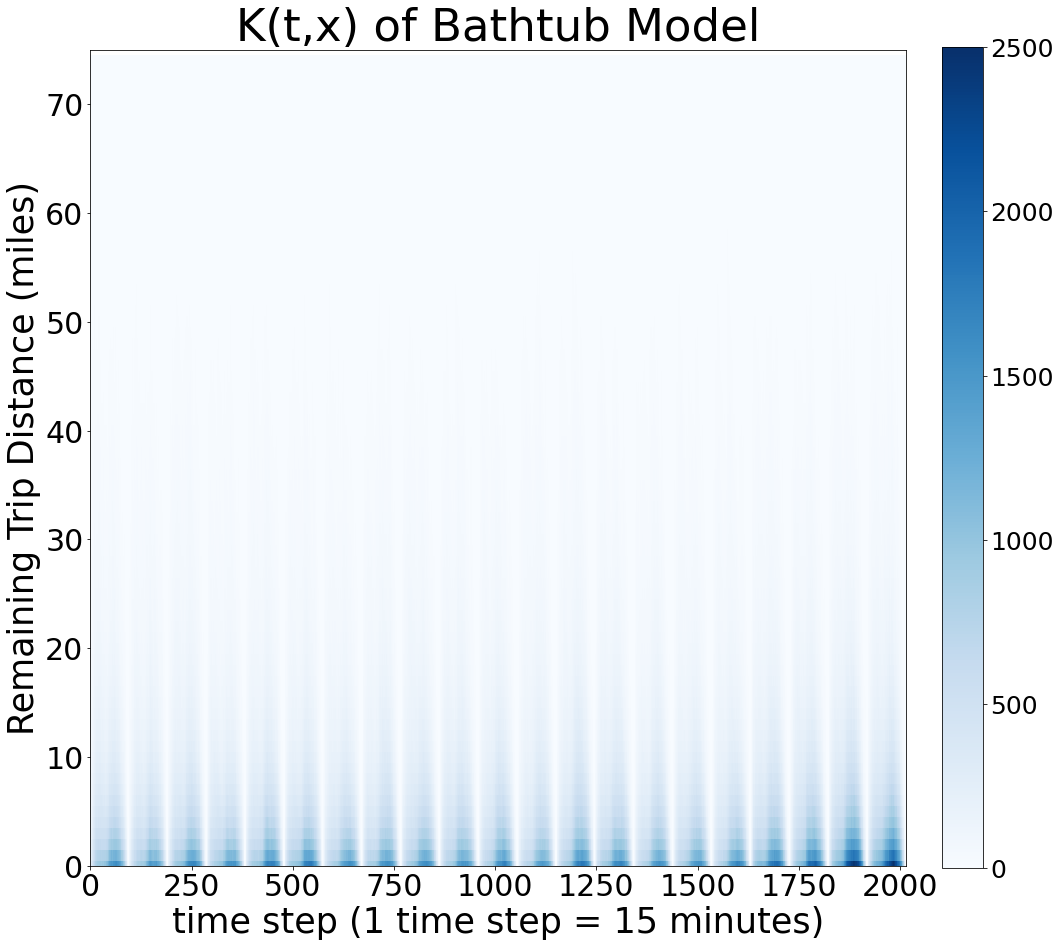

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 15 # unit: miles
Size_timestep = 2 # 2: 30min, 3: 60min
size_input = int(N_diststep/Size_diststep)*int(N_timestep/Size_timestep) # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  5040
N_u =  1008
N_f =  2016


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)][:,range(0,N_timestep,Size_timestep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(1008, 2)

In [12]:
X_u_test.shape

(4032, 2)

In [13]:
X_u_train

array([[0.2027027 , 0.10223325],
       [0.40540541, 0.20248139],
       [0.        , 0.14193548],
       ...,
       [0.60810811, 0.8516129 ],
       [0.        , 0.78908189],
       [0.40540541, 0.43672457]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u
    
    def loss(self,x,y):

        loss_u = self.loss_BC(x,y)

        loss = loss_u

        return loss, loss_u
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u= self.loss(X_u_train, u_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u = self.loss(X_u_train, u_train)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        
        tf.print(loss_value, loss_u, error_vec)

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.027868663053341926 0.027868663053341926 0.8114603315954733
0.023312326464373589 0.023312326464373589 0.7416840758623584
0.018850878177667691 0.018850878177667691 0.6664514298148647
0.018521631723510578 0.018521631723510578 0.6634679832058014
0.018349273694355864 0.018349273694355864 0.6630078122269147
0.018213702367223712 0.018213702367223712 0.6616774489317263
0.017692585983841193 0.017692585983841193 0.6556955042193591
0.017105119336777927 0.017105119336777927 0.6487220522188604
0.016276022295515332 0.016276022295515332 0.6337604942477095
0.015286775249188372 0.015286775249188372 0.6122205170636743
0.015181900735998418 0.015181900735998418 0.6032193306865804
0.014718915242991562 0.014718915242991562 0.594993172366792
0.014658529051587132 0.014658529051587132 0.5940677689124032
0.014243169376189959 0.014243169376189959 0.588062562478952
0.013970285704507158 0.013970285704507158 0.5852141932347313
0.013739759433247012 0.013739759433247012 0.580953097408246
0.013395118199408043 0.0133

0.0081354312239553025 0.0081354312239553025 0.43427721687726506
0.0081348807838246585 0.0081348807838246585 0.4342584578750604
0.0081342495243331842 0.0081342495243331842 0.43430260836700607
0.0081326041705028183 0.0081326041705028183 0.43401627606419957
0.0081319139981664724 0.0081319139981664724 0.43391155750706056
0.00813109295194285 0.00813109295194285 0.43333854611211503
0.00813040525029896 0.00813040525029896 0.433249372837719
0.00813023497903439 0.00813023497903439 0.43309317022445776
0.0081301204134226132 0.0081301204134226132 0.4329693481229782
0.0081298682370135513 0.0081298682370135513 0.43285926224723925
0.0081296964678467983 0.0081296964678467983 0.43290572414073425
0.00812923499885157 0.00812923499885157 0.4328497255008993
0.0081290816310570987 0.0081290816310570987 0.4328231850750565
0.00812898393879112 0.00812898393879112 0.432607373934656
0.0081289207283120873 0.0081289207283120873 0.4326914233313903
0.0081288221413853383 0.0081288221413853383 0.4327926986348002
0.0081

0.0081177276950905649 0.0081177276950905649 0.4317564374696988
0.0081176603657643134 0.0081176603657643134 0.4317694301216536
0.00811756547010292 0.00811756547010292 0.4314976506245681
0.0081174560197579976 0.0081174560197579976 0.43144139295004313
0.0081174255189558 0.0081174255189558 0.43157815813882516
0.00811740254071763 0.00811740254071763 0.43150990068362327
0.0081173959095261639 0.0081173959095261639 0.43148639155034824
0.0081173869142019926 0.0081173869142019926 0.43146745872321274
0.00811737391721284 0.00811737391721284 0.4314383032442714
0.008117355383186935 0.008117355383186935 0.4314246298177034
0.0081173168245095764 0.0081173168245095764 0.4313949870388443
0.0081172857630291834 0.0081172857630291834 0.4313661501868595
0.00811724298978105 0.00811724298978105 0.4313210481579367
0.0081172099040614128 0.0081172099040614128 0.4312390471717371
0.008117205154751686 0.008117205154751686 0.4312503077661548
0.0081171870289658953 0.0081171870289658953 0.4311982957343984
0.00811717943

0.0081054445939414636 0.0081054445939414636 0.4309041455542781
0.0081053214254285331 0.0081053214254285331 0.4308435749943352
0.0081052073822513934 0.0081052073822513934 0.43085044122953375
0.0081050314240080166 0.0081050314240080166 0.43089115551965235
0.0081047310167576669 0.0081047310167576669 0.4310354032187111
0.0081044881337928032 0.0081044881337928032 0.431410392355652
0.0081042617673360278 0.0081042617673360278 0.43102983070712697
0.0081039948253690559 0.0081039948253690559 0.43082452281159683
0.00810386770952407 0.00810386770952407 0.43092030368502626
0.0081036049061357779 0.0081036049061357779 0.43101014045209646
0.0081034300846740889 0.0081034300846740889 0.43104072624238465
0.00810332882424754 0.00810332882424754 0.4308602860895055
0.008103233158809937 0.008103233158809937 0.4307344112903844
0.0081031167397671664 0.0081031167397671664 0.4311760999860598
0.0081029508081287456 0.0081029508081287456 0.4310497285390972
0.0081028471984959625 0.0081028471984959625 0.4309051760761

0.0080251834287428415 0.0080251834287428415 0.43740430936873187
0.0080234672211891272 0.0080234672211891272 0.43655363796773294
0.0080230877455898363 0.0080230877455898363 0.4359036591938801
0.0080221771357448478 0.0080221771357448478 0.4365365250295273
0.0080209134627430168 0.0080209134627430168 0.43683725007293683
0.00801896612032796 0.00801896612032796 0.43672480960115767
0.008017791257041355 0.008017791257041355 0.4371261339188828
0.0080159437418493556 0.0080159437418493556 0.4373421765088176
0.0080144622476474719 0.0080144622476474719 0.437366160349357
0.008011828159723124 0.008011828159723124 0.43625176574138536
0.0080110722679263852 0.0080110722679263852 0.4366653680335813
0.0080096668894812772 0.0080096668894812772 0.43719070959580475
0.0080076041992384588 0.0080076041992384588 0.4377229681336574
0.0080063153772136735 0.0080063153772136735 0.4371948655908255
0.0080053312459750763 0.0080053312459750763 0.4374761289002995
0.0080043475043937752 0.0080043475043937752 0.436819865578

0.0079537337361135479 0.0079537337361135479 0.438671384211412
0.0079536986810401274 0.0079536986810401274 0.43866883470858514
0.0079536838376807611 0.0079536838376807611 0.4386705485781009
0.007953623384679958 0.007953623384679958 0.4387116274720609
0.0079535755624374465 0.0079535755624374465 0.4387157610385757
0.007953517873319646 0.007953517873319646 0.4386964066166878
0.0079534813198395785 0.0079534813198395785 0.438787433676749
0.0079534345749742684 0.0079534345749742684 0.4386960158364375
0.0079533843647639855 0.0079533843647639855 0.4386745534824476
0.00795332410055967 0.00795332410055967 0.4385255016824022
0.0079532892355427785 0.0079532892355427785 0.4385613210334055
0.00795325272847061 0.00795325272847061 0.43859290064686823
0.0079532185525381938 0.0079532185525381938 0.43873799604991043
0.0079532039862519888 0.0079532039862519888 0.4386760166351726
0.0079531660772997111 0.0079531660772997111 0.4386178806689548
0.00795307463005315 0.00795307463005315 0.4384654468471809
0.00795

0.0079380453547499841 0.0079380453547499841 0.43935042241354433
0.0079380066605268 0.0079380066605268 0.4394143551713122
0.0079379681945497844 0.0079379681945497844 0.43938957727244354
0.0079378952367727251 0.0079378952367727251 0.4393939231052722
0.0079378523467758724 0.0079378523467758724 0.4396561246261026
0.0079378408950604665 0.0079378408950604665 0.43958746602700205
0.00793783404460181 0.00793783404460181 0.43957272372749495
0.0079378306502006484 0.0079378306502006484 0.43958351958627345
0.0079378277390638255 0.0079378277390638255 0.4395832494052048
0.0079378172052631119 0.0079378172052631119 0.4395740927724515
0.0079378055734608283 0.0079378055734608283 0.439562727509086
0.00793779576277295 0.00793779576277295 0.4395740576907037
0.0079377910633483678 0.0079377910633483678 0.4395779726896591
0.0079377873713819772 0.0079377873713819772 0.4396542263675817
0.0079377823414880921 0.0079377823414880921 0.43963082526001396
0.0079377756464464235 0.0079377756464464235 0.4396281910927245
0

0.0079312754846273589 0.0079312754846273589 0.44000373328876646
0.0079312141441147573 0.0079312141441147573 0.43999591750497447
0.0079311543736434228 0.0079311543736434228 0.44010246614851856
0.0079311175067177733 0.0079311175067177733 0.44010662590956773
0.0079310971022192641 0.0079310971022192641 0.440159834149964
0.0079310446764326459 0.0079310446764326459 0.4402080352640775
0.0079309830539777589 0.0079309830539777589 0.4399716368713437
0.0079309637719253666 0.0079309637719253666 0.44004448305043076
0.007930951027551033 0.007930951027551033 0.4401386996234796
0.0079309180929897534 0.0079309180929897534 0.44020113154945145
0.007930905963485892 0.007930905963485892 0.44011969551673946
0.007930896646991422 0.007930896646991422 0.4401115478333744
0.0079308742476067728 0.0079308742476067728 0.4401276654444972
0.0079308633220347476 0.0079308633220347476 0.4401472171923597
0.0079308441068079178 0.0079308441068079178 0.4401641482134771
0.0079308111117854154 0.0079308111117854154 0.440170916

0.007889146615577226 0.007889146615577226 0.4399503487314594
0.00788876543105659 0.00788876543105659 0.4399848622748014
0.0078885272298803814 0.0078885272298803814 0.4397454189370625
0.0078882056571481628 0.0078882056571481628 0.4395504662444428
0.0078876757294593283 0.0078876757294593283 0.43986727527435293
0.00788732750885646 0.00788732750885646 0.44025835356029525
0.0078870779115081113 0.0078870779115081113 0.4404477206749876
0.007886523090005761 0.007886523090005761 0.4413079777232486
0.007885996594344186 0.007885996594344186 0.44088048908309535
0.0078855453635635672 0.0078855453635635672 0.4407285926931574
0.00788529473584927 0.00788529473584927 0.4406464112906869
0.0078850744414739934 0.0078850744414739934 0.44049893395843837
0.0078849054684954172 0.0078849054684954172 0.4406209951235468
0.0078846688890548376 0.0078846688890548376 0.44080698343998237
0.0078839130608074383 0.0078839130608074383 0.44126097265734326
0.0078828638590368368 0.0078828638590368368 0.44155660092808807
0.0

0.007832052744482846 0.007832052744482846 0.44233755520534174
0.0078319566925786361 0.0078319566925786361 0.4423684715512695
0.00783191992814646 0.00783191992814646 0.4424016290330812
0.00783185402261735 0.00783185402261735 0.4423790603476581
0.007831829825960486 0.007831829825960486 0.4423081538841489
0.0078317989437844716 0.0078317989437844716 0.44230114685984806
0.0078317428782127673 0.0078317428782127673 0.442194766215588
0.0078316765897089129 0.0078316765897089129 0.4420275918188614
0.0078316543664236349 0.0078316543664236349 0.4419802013403802
0.0078316348533192161 0.0078316348533192161 0.44196458022125973
0.0078316031702528825 0.0078316031702528825 0.4419864939340221
0.00783144639249618 0.00783144639249618 0.4420220730748927
0.0078311771843046669 0.0078311771843046669 0.4420703896719508
0.007830935536918552 0.007830935536918552 0.44193433345212685
0.0078304920206452716 0.0078304920206452716 0.4417906351745324
0.0078301442280372686 0.0078301442280372686 0.4416302449416512
0.00782

0.0078077569623924026 0.0078077569623924026 0.4418788591085779
0.0078075244147570479 0.0078075244147570479 0.44168920869009887
0.0078071982762556291 0.0078071982762556291 0.442035643250219
0.0078070374692122586 0.0078070374692122586 0.4417493037265626
0.007806731037170808 0.007806731037170808 0.44169472117276554
0.0078062001930910719 0.0078062001930910719 0.4410498844922271
0.0078060253128610169 0.0078060253128610169 0.4416743388341915
0.007805598506987213 0.007805598506987213 0.44167145962980053
0.0078053320368275756 0.0078053320368275756 0.44120963805839186
0.0078051786072904864 0.0078051786072904864 0.4415882247844782
0.0078047460428681383 0.0078047460428681383 0.44142605501644944
0.007804407027013926 0.007804407027013926 0.44138110099333117
0.0078039598671409945 0.0078039598671409945 0.4415650807550344
0.0078034770310788509 0.0078034770310788509 0.4413018796245375
0.0078030142490763139 0.0078030142490763139 0.44119443518858387
0.0078020258359553715 0.0078020258359553715 0.441118825

0.0076287865759432534 0.0076287865759432534 0.4442054040183327
0.0076267852934239714 0.0076267852934239714 0.44453490494204967
0.0076229975060793324 0.0076229975060793324 0.4446500515208564
0.0076193560080652246 0.0076193560080652246 0.44628779249593653
0.0076158898591150914 0.0076158898591150914 0.44518987180463987
0.00761469589167184 0.00761469589167184 0.44439927836121546
0.007612893589902507 0.007612893589902507 0.445498938909206
0.0076119546285533324 0.0076119546285533324 0.44522772730781657
0.0076111206104737348 0.0076111206104737348 0.44497190301521716
0.0076107678712711612 0.0076107678712711612 0.4448264151248406
0.0076106056857210141 0.0076106056857210141 0.44514746304272984
0.0076104329702470592 0.0076104329702470592 0.4449107285175993
0.0076101326894346183 0.0076101326894346183 0.4448883653822338
0.0076097279688155843 0.0076097279688155843 0.4447448841607092
0.0076094381214815276 0.0076094381214815276 0.44473051372161015
0.0076089759909145393 0.0076089759909145393 0.44426751

0.0074943748492028008 0.0074943748492028008 0.4384628414609143
0.0074940278709009073 0.0074940278709009073 0.43837201204036313
0.0074928773396671679 0.0074928773396671679 0.4388312822466338
0.0074919535854158165 0.0074919535854158165 0.4385363553984368
0.00749034743707934 0.00749034743707934 0.43865903883494833
0.00748968330660782 0.00748968330660782 0.438614645338144
0.0074887802136210943 0.0074887802136210943 0.439277348013885
0.0074880157180131088 0.0074880157180131088 0.4395641175419962
0.0074873987253254769 0.0074873987253254769 0.4387707731108941
0.0074870926099307568 0.0074870926099307568 0.4388333779729351
0.0074865873141091175 0.0074865873141091175 0.43902187867537856
0.0074857754256356848 0.0074857754256356848 0.43888865900262813
0.0074840796337317245 0.0074840796337317245 0.43892983106368294
0.0074823090169549846 0.0074823090169549846 0.4389884868788936
0.0074807759862465326 0.0074807759862465326 0.43885819269465143
0.0074787430572709462 0.0074787430572709462 0.4388165923439

0.007260995010125398 0.007260995010125398 0.43970477414449505
0.007258093039041057 0.007258093039041057 0.4376712829908149
0.007256865510049503 0.007256865510049503 0.4382073242153705
0.0072562417888527488 0.0072562417888527488 0.43834289492616463
0.0072560046422412913 0.0072560046422412913 0.43814909721227363
0.0072557782350906111 0.0072557782350906111 0.4378736890782571
0.0072553693485918527 0.0072553693485918527 0.4379586901457225
0.007254802790024906 0.007254802790024906 0.4382474128186986
0.0072541529212327262 0.0072541529212327262 0.43795551581937786
0.0072537407452668342 0.0072537407452668342 0.4376968360254581
0.007253532979514787 0.007253532979514787 0.4376591859213958
0.0072533349620154969 0.0072533349620154969 0.4378751825015829
0.0072531346137537827 0.0072531346137537827 0.4375807145048944
0.0072529438695700423 0.0072529438695700423 0.4376222358153759
0.0072526906611566 0.0072526906611566 0.43766497896656026
0.0072525550601082386 0.0072525550601082386 0.4377691262326488
0.0

0.0071157588723901105 0.0071157588723901105 0.44599885882295437
0.0071153916351927669 0.0071153916351927669 0.44575960648836227
0.0071148937775529046 0.0071148937775529046 0.44566240762443843
0.0071145243364270474 0.0071145243364270474 0.4456292748562583
0.0071144190898169641 0.0071144190898169641 0.44474287737063617
0.00711395296813266 0.00711395296813266 0.44512051278435977
0.007113579291588722 0.007113579291588722 0.445225410620047
0.00711283287421325 0.00711283287421325 0.4448393223038567
0.0071126512865515405 0.0071126512865515405 0.4445528161145179
0.0071122684575168375 0.0071122684575168375 0.4436959151623464
0.00711166975734785 0.00711166975734785 0.443850671136359
0.0071108422581721807 0.0071108422581721807 0.44362136383539796
0.0071099167665524821 0.0071099167665524821 0.4431743005764478
0.0071093001386114624 0.0071093001386114624 0.44243727295057544
0.0071081846591063329 0.0071081846591063329 0.4422403451230164
0.0071066065011089873 0.0071066065011089873 0.44232558143162326


0.0069315236057677114 0.0069315236057677114 0.43837385274477775
0.0069304258261341989 0.0069304258261341989 0.4390785503282434
0.0069298755811492531 0.0069298755811492531 0.4390340077356332
0.0069289147826196145 0.0069289147826196145 0.4389117670713471
0.0069273233085351609 0.0069273233085351609 0.4387902940227822
0.0069252671739535232 0.0069252671739535232 0.4383130404977973
0.006923428213818506 0.006923428213818506 0.4378889374834421
0.0069226745844801867 0.0069226745844801867 0.4388534148791253
0.0069212477997916992 0.0069212477997916992 0.4374613027811477
0.006920255612746699 0.006920255612746699 0.4374431233021351
0.0069194015321026626 0.0069194015321026626 0.43792193126479406
0.0069184889777535357 0.0069184889777535357 0.4371124986312137
0.0069174325498841879 0.0069174325498841879 0.43729225207845224
0.00691668580618013 0.00691668580618013 0.4366636816040124
0.0069160968465717433 0.0069160968465717433 0.4365407904695334
0.0069156002655909633 0.0069156002655909633 0.43727442406182

0.0068422117629356053 0.0068422117629356053 0.4305097660231789
0.0068413515625555914 0.0068413515625555914 0.4300986712940842
0.0068409808978824333 0.0068409808978824333 0.43053131910143905
0.0068405014225253677 0.0068405014225253677 0.43076982902535477
0.0068398556533767968 0.0068398556533767968 0.430247629791984
0.0068394894498825937 0.0068394894498825937 0.43009702202285593
0.0068390056998444 0.0068390056998444 0.43014740062981877
0.00683803212454087 0.00683803212454087 0.4303204082952641
0.0068374678672123617 0.0068374678672123617 0.43018753090887324
0.00683723140778048 0.00683723140778048 0.4308793845782134
0.0068363602336689606 0.0068363602336689606 0.4310270530513504
0.0068358451380660856 0.0068358451380660856 0.4306608209236079
0.006835283509876367 0.006835283509876367 0.43077057955037434
0.006833271049638971 0.006833271049638971 0.4311062171399754
0.0068330221423065739 0.0068330221423065739 0.4307297684332725
0.0068318146145124369 0.0068318146145124369 0.43111051044003423
0.00

0.0067104903380592607 0.0067104903380592607 0.43240148755291197
0.006708356967271639 0.006708356967271639 0.4321081367936881
0.0067069453981880283 0.0067069453981880283 0.4326907849656303
0.0067059423507997646 0.0067059423507997646 0.4337587719590817
0.0067042520074973369 0.0067042520074973369 0.4337475609102386
0.006702527254473168 0.006702527254473168 0.4332233553693567
0.0067017015133476543 0.0067017015133476543 0.43280139490352715
0.0066990786899894976 0.0066990786899894976 0.4330778735247343
0.0066969761064516369 0.0066969761064516369 0.4327587543590012
0.0066934490501385545 0.0066934490501385545 0.43447626130641004
0.0066906884765668227 0.0066906884765668227 0.434429977780443
0.0066871632421235489 0.0066871632421235489 0.4349538046280471
0.0066823121910069188 0.0066823121910069188 0.4327865247795277
0.0066776512167965691 0.0066776512167965691 0.43337552127337114
0.0066752909025691223 0.0066752909025691223 0.4356660040811197
0.0066646950744519932 0.0066646950744519932 0.4341994251

0.0063575391862408228 0.0063575391862408228 0.4335031804159184
0.0063568090920987251 0.0063568090920987251 0.4336675442646367
0.0063564298879569157 0.0063564298879569157 0.433744610248603
0.0063561595682300812 0.0063561595682300812 0.43377180268457105
0.0063557314911525456 0.0063557314911525456 0.4339967962263172
0.0063554650541218487 0.0063554650541218487 0.4337579978470703
0.0063551778320744042 0.0063551778320744042 0.43399823393419384
0.0063548532600890065 0.0063548532600890065 0.43427147309281516
0.0063544653623323561 0.0063544653623323561 0.43408934753106965
0.0063540826550480675 0.0063540826550480675 0.4341233456815983
0.0063534893859766269 0.0063534893859766269 0.4342487395983337
0.0063525476060081439 0.0063525476060081439 0.4349026347156178
0.0063519524991712045 0.0063519524991712045 0.4347532262184144
0.0063507757846693637 0.0063507757846693637 0.4347314679319685
0.0063498767116546458 0.0063498767116546458 0.4344186639505207
0.00634868576344622 0.00634868576344622 0.4347841426

0.0061457630872324073 0.0061457630872324073 0.43331908211743847
0.00614404807199451 0.00614404807199451 0.43286559059148705
0.0061409041486497852 0.0061409041486497852 0.43302643330781226
0.0061392317426132 0.0061392317426132 0.4351391873693325
0.0061362652076636945 0.0061362652076636945 0.43376251682335837
0.0061334189358981626 0.0061334189358981626 0.4347680134687514
0.0061306576496642185 0.0061306576496642185 0.43530926163670525
0.0061272466525033164 0.0061272466525033164 0.4351620906875581
0.0061251925751034508 0.0061251925751034508 0.43622200351817436
0.0061238271074035792 0.0061238271074035792 0.4360126402765131
0.00611868345102791 0.00611868345102791 0.4347773437098464
0.0061160716449855049 0.0061160716449855049 0.4334650556354898
0.0061116996974567989 0.0061116996974567989 0.4328685376883559
0.00610909880548468 0.00610909880548468 0.4318085914417616
0.0061038566464355435 0.0061038566464355435 0.4297948994987235
0.0061031793425675137 0.0061031793425675137 0.42930621687744713
0.0

0.0058325800081163639 0.0058325800081163639 0.4258517625490605
0.0058312434846081009 0.0058312434846081009 0.424800305038285
0.0058292493436052015 0.0058292493436052015 0.42431150207152457
0.0058266073623024564 0.0058266073623024564 0.422589385113839
0.0058256304532203866 0.0058256304532203866 0.4224365992477551
0.0058220758632481322 0.0058220758632481322 0.42271629902368824
0.0058165271786292817 0.0058165271786292817 0.4215828976862426
0.0058121351940274655 0.0058121351940274655 0.42339934410030644
0.00580879984843435 0.00580879984843435 0.42283929120467234
0.0058057819405113991 0.0058057819405113991 0.4221330728566724
0.0058043471315191069 0.0058043471315191069 0.42309440341985105
0.0058026058518541425 0.0058026058518541425 0.4219104148248217
0.0058014286450160683 0.0058014286450160683 0.4217566011741594
0.0057993562184823514 0.0057993562184823514 0.421461572346737
0.005796983132391173 0.005796983132391173 0.4211918600623126
0.00579575162064015 0.00579575162064015 0.4215764761561602


0.0056684219908219331 0.0056684219908219331 0.42321047191851835
0.0056675260291445149 0.0056675260291445149 0.4230173766831169
0.0056662442130227366 0.0056662442130227366 0.4217963816360914
0.0056646671876010588 0.0056646671876010588 0.4223593553429265
0.0056635809238384958 0.0056635809238384958 0.4223767130069637
0.0056630902846651855 0.0056630902846651855 0.4225671796462956
0.0056623478740376945 0.0056623478740376945 0.4212108624648177
0.0056615819345267335 0.0056615819345267335 0.42099505691930245
0.00565916532047075 0.00565916532047075 0.420609327055435
0.0056541474509738364 0.0056541474509738364 0.4197406193218006
0.0056473280117310563 0.0056473280117310563 0.42058672990905427
0.0056451148891712693 0.0056451148891712693 0.4188206380578728
0.0056418066448115037 0.0056418066448115037 0.4184098877896809
0.0056342485387368985 0.0056342485387368985 0.4170642311796265
0.0056259280607251477 0.0056259280607251477 0.4153733662888812
0.0056224550678593034 0.0056224550678593034 0.41690935746

0.0052318814505524069 0.0052318814505524069 0.3926088127662294
0.0052271526153766989 0.0052271526153766989 0.3927352661632697
0.0052257757338877884 0.0052257757338877884 0.3941168414318742
0.0052215276092474885 0.0052215276092474885 0.3931730367651931
0.0052185249892406612 0.0052185249892406612 0.39312720856274425
0.0052134416036410357 0.0052134416036410357 0.3928530760546817
0.0052083024656637174 0.0052083024656637174 0.3927965286232053
0.0052043718906298192 0.0052043718906298192 0.3924155166650752
0.0051984046080705672 0.0051984046080705672 0.39249764677859467
0.0051959113159269947 0.0051959113159269947 0.3915723084679982
0.005191358403654092 0.005191358403654092 0.39140045831661346
0.0051880785825107866 0.0051880785825107866 0.39037400743501216
0.005183252242951175 0.005183252242951175 0.38983365212380244
0.0051804848740768907 0.0051804848740768907 0.3892024436320297
0.0051778532256568054 0.0051778532256568054 0.3883041480545421
0.0051745815300610508 0.0051745815300610508 0.38823612

0.004895448831537046 0.004895448831537046 0.3830486922511669
0.0048949529572743788 0.0048949529572743788 0.38304393698063727
0.0048947384730680622 0.0048947384730680622 0.38316420297277237
0.00489466966783566 0.00489466966783566 0.38273993423891595
0.0048945552770857251 0.0048945552770857251 0.3828374182740629
0.0048944998823387178 0.0048944998823387178 0.38285145641208485
0.0048944088158093257 0.0048944088158093257 0.3827391580377779
0.0048943285847768154 0.0048943285847768154 0.382624151457003
0.0048941291939277615 0.0048941291939277615 0.38238529067081123
0.00489396596404003 0.00489396596404003 0.3822526899168065
0.0048936556272013232 0.0048936556272013232 0.3821216710915369
0.0048932921369033693 0.0048932921369033693 0.38203127536147674
0.0048928140620397515 0.0048928140620397515 0.38202811316060775
0.00489256954983154 0.00489256954983154 0.38187073189331133
0.0048921218228615629 0.0048921218228615629 0.38229185630968116
0.0048915018883489252 0.0048915018883489252 0.381081231991191

0.00482167824559031 0.00482167824559031 0.3743053643010517
0.0048211701300759054 0.0048211701300759054 0.37471201687371597
0.0048205574917709916 0.0048205574917709916 0.374679259088668
0.0048191782175273038 0.0048191782175273038 0.37503029502121704
0.0048172154925227211 0.0048172154925227211 0.37500068062487457
0.004816235579347761 0.004816235579347761 0.3748564007878438
0.00481513087092083 0.00481513087092083 0.37468287440914355
0.004814127322485982 0.004814127322485982 0.3745545552730902
0.0048127225759513658 0.0048127225759513658 0.37469962854185657
0.0048105880107943214 0.0048105880107943214 0.3746510255768152
0.0048086428130951738 0.0048086428130951738 0.3740676458917096
0.0048076330052741166 0.0048076330052741166 0.3736196061655571
0.0048060425063381476 0.0048060425063381476 0.3746813345965641
0.0048040781746267252 0.0048040781746267252 0.3743492900156323
0.0048018783210342945 0.0048018783210342945 0.3743302061545399
0.0048015163888804821 0.0048015163888804821 0.37419492482388966

0.0047242571582592529 0.0047242571582592529 0.37354300623720454
0.0047241204499540706 0.0047241204499540706 0.3731743975171499
0.0047239947272193685 0.0047239947272193685 0.3731329971053416
0.00472386745396665 0.00472386745396665 0.3729445537213368
0.0047238106822037555 0.0047238106822037555 0.3727374382046156
0.0047237717611032012 0.0047237717611032012 0.37270429221531715
0.0047237306539452172 0.0047237306539452172 0.37256599288120784
0.0047237031934446085 0.0047237031934446085 0.37259137008716114
0.0047236773479397394 0.0047236773479397394 0.37254629078347234
0.00472362533977118 0.00472362533977118 0.37251480430213
0.0047235752590363582 0.0047235752590363582 0.3725512238664319
0.0047235289863145 0.0047235289863145 0.3726001511251416
0.0047235018706367309 0.0047235018706367309 0.37260987768031795
0.0047234499039597727 0.0047234499039597727 0.3726042118821513
0.00472341872910389 0.00472341872910389 0.3726134268075968
0.0047232916256935839 0.0047232916256935839 0.3725851398512354
0.0047

0.0045194194857437423 0.0045194194857437423 0.3667593875078186
0.0045193533114526122 0.0045193533114526122 0.3668460665712234
0.0045192612612369809 0.0045192612612369809 0.3669156880857106
0.0045191689980917833 0.0045191689980917833 0.3669336954594201
0.0045190881869513954 0.0045190881869513954 0.36688764712889194
0.00451901838087756 0.00451901838087756 0.36680985022758045
0.0045189301732295965 0.0045189301732295965 0.3667381461773867
0.0045188458453489745 0.0045188458453489745 0.3665602194827461
0.0045187118654711218 0.0045187118654711218 0.3666674627199897
0.0045184649041726923 0.0045184649041726923 0.3666967835848739
0.0045182389782147531 0.0045182389782147531 0.36675229098146056
0.0045179291135041709 0.0045179291135041709 0.36725496543610403
0.0045177483436605196 0.0045177483436605196 0.367097345444444
0.0045173120096921749 0.0045173120096921749 0.3668017028798238
0.0045169764086084568 0.0045169764086084568 0.36650241278631
0.004516791590172123 0.004516791590172123 0.36644539361656

0.00446311002993165 0.00446311002993165 0.3704278163065509
0.0044628837077756046 0.0044628837077756046 0.37058985583384946
0.0044627313633232345 0.0044627313633232345 0.3708635044794199
0.0044625474531901944 0.0044625474531901944 0.3706910949244242
0.0044624024777109427 0.0044624024777109427 0.3707768708353522
0.0044622160781514113 0.0044622160781514113 0.3708405052629704
0.0044620741799731075 0.0044620741799731075 0.3709248968600424
0.0044619310456902282 0.0044619310456902282 0.3712079720562673
0.0044617697810442926 0.0044617697810442926 0.3711538039033371
0.0044616459513116121 0.0044616459513116121 0.3715870593627401
0.0044615656091087632 0.0044615656091087632 0.3719583130767383
0.0044612196386116269 0.0044612196386116269 0.37233224313982677
0.0044609111620782646 0.0044609111620782646 0.3726264733795001
0.0044605422654815765 0.0044605422654815765 0.37286384948660845
0.0044599107881780264 0.0044599107881780264 0.37314356584683545
0.0044596946251896676 0.0044596946251896676 0.373203512

0.0043832712460462019 0.0043832712460462019 0.3590217069106842
0.0043776062932065311 0.0043776062932065311 0.3578375961066483
0.004369809574363729 0.004369809574363729 0.3562196636493393
0.00436338275391069 0.00436338275391069 0.3578748354514658
0.0043573680526625257 0.0043573680526625257 0.356678624376858
0.004352131599540285 0.004352131599540285 0.3547019149468428
0.00434797482389407 0.00434797482389407 0.35403494665661484
0.0043452121663299179 0.0043452121663299179 0.35311406123204087
0.0043420733981548174 0.0043420733981548174 0.353593354816154
0.00433841646004915 0.00433841646004915 0.3534897061884114
0.0043364788016230036 0.0043364788016230036 0.3524717591035321
0.0043335310395044126 0.0043335310395044126 0.3518808113075987
0.0043307954756966272 0.0043307954756966272 0.35081882517789376
0.004328639014576057 0.004328639014576057 0.3517951309518055
0.0043278992930962891 0.0043278992930962891 0.35077216255282007
0.0043242753933816526 0.0043242753933816526 0.35042229175174555
0.00432

0.004112974827071879 0.004112974827071879 0.33480181008163634
0.0041125873804382686 0.0041125873804382686 0.3350429535252021
0.00411239669913823 0.00411239669913823 0.33502992704534607
0.0041120109810123982 0.0041120109810123982 0.33521568674961416
0.0041115090823332931 0.0041115090823332931 0.3353626405552524
0.0041108683163075723 0.0041108683163075723 0.33530841468239003
0.0041103188092875614 0.0041103188092875614 0.3348531840450769
0.0041099721479293189 0.0041099721479293189 0.3349992978420384
0.0041096494268488722 0.0041096494268488722 0.3348514765459609
0.0041093702948508306 0.0041093702948508306 0.3347677969952491
0.0041091663174005217 0.0041091663174005217 0.3348205514249485
0.0041088605127169381 0.0041088605127169381 0.3349767478616505
0.0041087104923435607 0.0041087104923435607 0.3349919454807745
0.0041086173254156607 0.0041086173254156607 0.3349035720763748
0.0041084803882185696 0.0041084803882185696 0.3349628781254558
0.0041082764783488511 0.0041082764783488511 0.33505095620

0.0040865614944583396 0.0040865614944583396 0.3384228527382906
0.0040862977395136656 0.0040862977395136656 0.3386330263898839
0.004086139947886422 0.004086139947886422 0.33893362313621317
0.0040859889034026708 0.0040859889034026708 0.3390759007146777
0.0040857791489904028 0.0040857791489904028 0.3391266729366231
0.0040856729131053381 0.0040856729131053381 0.3391908757173897
0.0040855594138020585 0.0040855594138020585 0.33906465253437357
0.0040853509686894461 0.0040853509686894461 0.33907516628984213
0.0040851576620752825 0.0040851576620752825 0.3391492661856431
0.0040849294124547042 0.0040849294124547042 0.3394597833749814
0.0040847940533855782 0.0040847940533855782 0.33937746553955106
0.0040845635015431528 0.0040845635015431528 0.339484503784595
0.0040844707440140376 0.0040844707440140376 0.33974550002476295
0.0040841802643154443 0.0040841802643154443 0.33976369073264745
0.0040840224369027124 0.0040840224369027124 0.3397346355959639
0.0040838538587040655 0.0040838538587040655 0.340045

0.00404552830754116 0.00404552830754116 0.32948319093358036
0.0040454522160351981 0.0040454522160351981 0.329415028395797
0.0040453760816771154 0.0040453760816771154 0.32930328501941775
0.0040452724719701877 0.0040452724719701877 0.32903104702225777
0.0040450923760208066 0.0040450923760208066 0.32845861435965734
0.004044858650549106 0.004044858650549106 0.3276729623912714
0.0040446935721634722 0.0040446935721634722 0.3268610537557554
0.00404432556095984 0.00404432556095984 0.32636923046648963
0.0040438771320283192 0.0040438771320283192 0.3262835277954608
0.0040430927425434329 0.0040430927425434329 0.3259030961246401
0.0040417834232897255 0.0040417834232897255 0.3247550131245283
0.0040410137325531852 0.0040410137325531852 0.32429397416583566
0.0040399359158727437 0.0040399359158727437 0.3233521724662326
0.0040393985459917618 0.0040393985459917618 0.3230792667325108
0.004039081178323297 0.004039081178323297 0.3221167605756094
0.0040385017539836783 0.0040385017539836783 0.3218075346226088

0.0039203759900390362 0.0039203759900390362 0.3205055427065649
0.003919695456488701 0.003919695456488701 0.320465751452023
0.0039186690502720917 0.0039186690502720917 0.320012763173985
0.0039173791512932387 0.0039173791512932387 0.32039784079040745
0.0039164855005332988 0.0039164855005332988 0.31988619683208
0.0039151268941744963 0.0039151268941744963 0.31982550058481884
0.0039144200486696153 0.0039144200486696153 0.3201973801807322
0.003914278363230223 0.003914278363230223 0.31993285182918235
0.003913301224154197 0.003913301224154197 0.3199775153999047
0.0039126180184788448 0.0039126180184788448 0.3199324162179572
0.003911269538568898 0.003911269538568898 0.31960896101032227
0.0039099038322241717 0.0039099038322241717 0.3186614219885445
0.0039096226164512986 0.0039096226164512986 0.31861998035266625
0.0039088084184475185 0.0039088084184475185 0.31817742601568366
0.0039082768195352084 0.0039082768195352084 0.31803106756790495
0.0039075747120828532 0.0039075747120828532 0.31794718224995

0.0037818304488818825 0.0037818304488818825 0.30974738318049766
0.0037810887199008288 0.0037810887199008288 0.310016045240898
0.0037798304590648088 0.0037798304590648088 0.3101541199529491
0.0037778824484095298 0.0037778824484095298 0.3105845470363496
0.0037759816157495632 0.0037759816157495632 0.3102642553133432
0.0037742784430697574 0.0037742784430697574 0.3105746647996793
0.003772986212613464 0.003772986212613464 0.31115529612161164
0.0037716359911421364 0.0037716359911421364 0.3111528686187622
0.0037691135042992336 0.0037691135042992336 0.31004131330469975
0.0037674515790339404 0.0037674515790339404 0.31042714614334094
0.0037661518233730856 0.0037661518233730856 0.31079897415853264
0.0037652069963661806 0.0037652069963661806 0.3106745805492774
0.0037642593905284289 0.0037642593905284289 0.31055402216163663
0.0037636698742995784 0.0037636698742995784 0.3106427736163307
0.0037620884848880839 0.0037620884848880839 0.3105745318398281
0.0037603883164869616 0.0037603883164869616 0.310859

0.0035591071341555232 0.0035591071341555232 0.32492836723410395
0.0035550945319382829 0.0035550945319382829 0.32510250118351197
0.0035516214106896876 0.0035516214106896876 0.3257493838202359
0.0035452851207243992 0.0035452851207243992 0.3265560217820954
0.0035391589128651217 0.0035391589128651217 0.3260698251966128
0.003535361757998776 0.003535361757998776 0.32655074397886263
0.0035326855796654136 0.0035326855796654136 0.3257450816047409
0.0035288350469263748 0.0035288350469263748 0.326265163914495
0.0035256752967200876 0.0035256752967200876 0.3260281965241159
0.0035242164512703606 0.0035242164512703606 0.3274428489584449
0.003523728622124348 0.003523728622124348 0.327792518440999
0.0035214050144336622 0.0035214050144336622 0.3270384623769293
0.0035199678074888932 0.0035199678074888932 0.3261100450497543
0.0035187424055678354 0.0035187424055678354 0.3267260103343674
0.0035162943246784227 0.0035162943246784227 0.32659273707569764
0.0035148581673212918 0.0035148581673212918 0.32683412950

0.0034717249911075062 0.0034717249911075062 0.31503260283915246
0.0034713143774323476 0.0034713143774323476 0.3145922193645053
0.0034702797162673633 0.0034702797162673633 0.3147733427109971
0.0034697307558317534 0.0034697307558317534 0.3152642067105462
0.0034693600228580417 0.0034693600228580417 0.3150891403433703
0.0034690360805679121 0.0034690360805679121 0.3143738525302384
0.0034685777024230356 0.0034685777024230356 0.31445336698312387
0.0034682906517647582 0.0034682906517647582 0.31452615612732154
0.0034680443903533512 0.0034680443903533512 0.31434602860527894
0.0034678261778136872 0.0034678261778136872 0.3142590465036384
0.0034675727330172072 0.0034675727330172072 0.31397741076235247
0.0034673871419893172 0.0034673871419893172 0.3137989605414039
0.0034670677420610475 0.0034670677420610475 0.3135444447608262
0.0034667570642021158 0.0034667570642021158 0.31315171243674034
0.0034661092444480748 0.0034661092444480748 0.31258725891868155
0.0034659704992596129 0.0034659704992596129 0.31

0.0033652795159958972 0.0033652795159958972 0.31803191713091183
0.0033638957495398768 0.0033638957495398768 0.31709301519134786
0.0033627596011218367 0.0033627596011218367 0.31680375590643306
0.0033618645017654547 0.0033618645017654547 0.31694454034659336
0.0033594129746043126 0.0033594129746043126 0.31782086085906397
0.0033584960698032295 0.0033584960698032295 0.3176172886732087
0.0033569112205584688 0.0033569112205584688 0.3175432217121283
0.0033560551801112195 0.0033560551801112195 0.31932964850039947
0.0033541704778766415 0.0033541704778766415 0.3183642456629678
0.0033525635461009325 0.0033525635461009325 0.31810377157508085
0.0033510145657456988 0.0033510145657456988 0.31755177241231763
0.0033500306165811303 0.0033500306165811303 0.3177082902858828
0.0033492478702765011 0.0033492478702765011 0.31808441766593687
0.0033489238969221682 0.0033489238969221682 0.31735661918571834
0.0033485505513726169 0.0033485505513726169 0.3170937934031454
0.0033480177258508135 0.0033480177258508135 0

0.0032628092085889423 0.0032628092085889423 0.32951203179971145
0.0032625746895028037 0.0032625746895028037 0.32957259501300973
0.0032616874915980835 0.0032616874915980835 0.3291988186639603
0.0032612440886747793 0.0032612440886747793 0.32942059513181665
0.0032606163662783727 0.0032606163662783727 0.3287845198452969
0.0032597397078009522 0.0032597397078009522 0.3292861840871751
0.0032588757730555268 0.0032588757730555268 0.32867897530033824
0.0032581007095903248 0.0032581007095903248 0.32849936948508324
0.0032570265888867559 0.0032570265888867559 0.3285287237404779
0.0032562100034908849 0.0032562100034908849 0.32855716111133026
0.0032554580231944144 0.0032554580231944144 0.32771766489132886
0.0032546350217290249 0.0032546350217290249 0.3269673562435397
0.0032537094634202315 0.0032537094634202315 0.3259633015815484
0.0032527700901293917 0.0032527700901293917 0.3253419400882065
0.0032524313297870888 0.0032524313297870888 0.32591322802577816
0.0032517755207398533 0.0032517755207398533 0.3

0.0032092944105958274 0.0032092944105958274 0.3281905329439985
0.0032089794318951354 0.0032089794318951354 0.3271038286793083
0.0032089131297422914 0.0032089131297422914 0.32661329801897565
0.0032086467221321122 0.0032086467221321122 0.32654218405858215
0.0032084535618595428 0.0032084535618595428 0.3266072213324618
0.0032083121033482046 0.0032083121033482046 0.3263613411344877
0.0032082282515198575 0.0032082282515198575 0.3263651010665809
0.0032081280878249428 0.0032081280878249428 0.3264262861533695
0.0032080624381157431 0.0032080624381157431 0.32620210028094915
0.0032078753599078629 0.0032078753599078629 0.3262916097598711
0.003207675057865675 0.003207675057865675 0.3263453446399226
0.0032074142812410045 0.0032074142812410045 0.3262399040988323
0.0032072596468570285 0.0032072596468570285 0.3264537624169377
0.0032070366872131231 0.0032070366872131231 0.3260864322464889
0.0032068468470918591 0.0032068468470918591 0.32612742640314407
0.0032067295834526141 0.0032067295834526141 0.3261256

0.0031757942939431598 0.0031757942939431598 0.309311934679496
0.0031757740919517541 0.0031757740919517541 0.3090583454025617
0.0031757213360303471 0.0031757213360303471 0.3086987664183878
0.0031756932959262074 0.0031756932959262074 0.30863693601219006
0.0031756689113381208 0.0031756689113381208 0.30838778220453356
0.003175645730503072 0.003175645730503072 0.30837168775207674
0.0031756210033412583 0.0031756210033412583 0.3083204863444601
0.003175580759397393 0.003175580759397393 0.3083029405604882
0.0031755324945956921 0.0031755324945956921 0.3082808187660931
0.0031754591738351687 0.0031754591738351687 0.30818345755045196
0.0031753635044318362 0.0031753635044318362 0.3080134441885624
0.0031752559356149406 0.0031752559356149406 0.3075652455254693
0.0031751385141626214 0.0031751385141626214 0.30725665296829147
0.0031749941104206167 0.0031749941104206167 0.3068524915157793
0.0031748628768093839 0.0031748628768093839 0.30670074232559724
0.0031746365586568484 0.0031746365586568484 0.30684996

0.0031612272303137524 0.0031612272303137524 0.3087298299290497
0.0031611498107657304 0.0031611498107657304 0.3086781846194106
0.0031611075073660396 0.0031611075073660396 0.30877714391098077
0.0031610764117023268 0.0031610764117023268 0.3088903786749962
0.0031610553088350377 0.0031610553088350377 0.30883583744411347
0.0031610329296977431 0.0031610329296977431 0.30895572847324265
0.0031610059749663014 0.0031610059749663014 0.30897034746633223
0.0031609737958833433 0.0031609737958833433 0.30902264660117973
0.0031609575961837376 0.0031609575961837376 0.3092461519232205
0.0031609192953691596 0.0031609192953691596 0.309265752824035
0.0031608692068058669 0.0031608692068058669 0.30928436711682805
0.0031608178266916507 0.0031608178266916507 0.3094394030898497
0.0031607741644878655 0.0031607741644878655 0.3095318821449718
0.0031607383477875754 0.0031607383477875754 0.3096579244079829
0.0031606691186033976 0.0031606691186033976 0.3096951842330221
0.003160587819780957 0.003160587819780957 0.309616

0.0031475585751304285 0.0031475585751304285 0.3008361478616338
0.0031475428737739483 0.0031475428737739483 0.3005714848455925
0.0031475242650407403 0.0031475242650407403 0.30061642802575517
0.0031475080932078128 0.0031475080932078128 0.3006314954455398
0.0031474891663391519 0.0031474891663391519 0.30060267768552584
0.0031474610274595978 0.0031474610274595978 0.30048554341061845
0.0031474474104460238 0.0031474474104460238 0.30048271521242964
0.003147433461778466 0.003147433461778466 0.30043206435713904
0.003147415124563228 0.003147415124563228 0.3003431340381588
0.0031473953329855552 0.0031473953329855552 0.30039432270211053
0.0031473770948321684 0.0031473770948321684 0.30042334392805603
0.0031473684137412125 0.0031473684137412125 0.3004402177403268
0.003147361410285876 0.003147361410285876 0.30043208341047073
0.0031473512440987924 0.0031473512440987924 0.30044668258360924
0.0031473461424705034 0.0031473461424705034 0.3003473256405895
0.0031473264153018018 0.0031473264153018018 0.300327

0.0031326247396375353 0.0031326247396375353 0.300500602669801
0.0031321813902491042 0.0031321813902491042 0.3000078839653289
0.0031316999285037643 0.0031316999285037643 0.2992198802706465
0.0031314046641080047 0.0031314046641080047 0.29911584858259366
0.0031310467274502127 0.0031310467274502127 0.2986183669632544
0.0031308484280797885 0.0031308484280797885 0.2985278837121789
0.0031305594080995145 0.0031305594080995145 0.29843593936031954
0.0031303574442172206 0.0031303574442172206 0.29856223493310013
0.0031301122851613442 0.0031301122851613442 0.2981807292155203
0.0031299549891128844 0.0031299549891128844 0.29829025022401373
0.0031298012897425956 0.0031298012897425956 0.2983688561678203
0.0031295661817990678 0.0031295661817990678 0.2984266649174124
0.0031293711403633582 0.0031293711403633582 0.2987489203181026
0.0031292079957883513 0.0031292079957883513 0.29871744912581294
0.0031289729514022927 0.0031289729514022927 0.29888120944364244
0.00312866769259076 0.00312866769259076 0.29899575

0.003117717669686357 0.003117717669686357 0.29562607903262933
0.0031176746975680996 0.0031176746975680996 0.29573894915320226
0.0031176153230716855 0.0031176153230716855 0.2957682845238519
0.0031176012222715872 0.0031176012222715872 0.2960337770050999
0.00311756755309874 0.00311756755309874 0.29598038645256336
0.0031175366657261779 0.0031175366657261779 0.2957552037237185
0.0031175010655564695 0.0031175010655564695 0.2957793729822601
0.0031174747744855784 0.0031174747744855784 0.2957499624785887
0.0031174452649731627 0.0031174452649731627 0.2957821905773851
0.003117426814119507 0.003117426814119507 0.29576933507495773
0.0031174096816889455 0.0031174096816889455 0.29579046079189425
0.0031173955306331731 0.0031173955306331731 0.295750479600887
0.0031173767485304076 0.0031173767485304076 0.29572996726843137
0.0031173577775105155 0.0031173577775105155 0.2956200035348876
0.0031173375026583494 0.0031173375026583494 0.29554502451024084
0.0031173078658093454 0.0031173078658093454 0.29544598858

0.00310238289501455 0.00310238289501455 0.2904703986542254
0.0031023276470265354 0.0031023276470265354 0.29046114599676737
0.003102291499076989 0.003102291499076989 0.2904170769395291
0.00310225725568712 0.00310225725568712 0.2903259013523268
0.0031021886340336321 0.0031021886340336321 0.29016650621136986
0.0031021491571328916 0.0031021491571328916 0.289914674783684
0.0031021157167539625 0.0031021157167539625 0.28995161876613174
0.0031020884632571074 0.0031020884632571074 0.2899090715158499
0.0031020718102018662 0.0031020718102018662 0.2899577450084412
0.0031020496902236924 0.0031020496902236924 0.2899167096217252
0.003102027516424714 0.003102027516424714 0.28990561285004035
0.0031019910352628128 0.0031019910352628128 0.28991054511194886
0.0031019815170188376 0.0031019815170188376 0.2900133891556419
0.0031019528036676592 0.0031019528036676592 0.2900437178699443
0.0031019147793137866 0.0031019147793137866 0.29011724513314896
0.00310188995390235 0.00310188995390235 0.29015539010269953
0.

0.0030980341617641571 0.0030980341617641571 0.28793095130766017
0.0030980084055492211 0.0030980084055492211 0.2879619526819747
0.0030979634399077053 0.0030979634399077053 0.2879834266937649
0.00309791729342874 0.00309791729342874 0.287848618050314
0.0030978954151440782 0.0030978954151440782 0.2876834536173416
0.0030978231314530489 0.0030978231314530489 0.28774756638135457
0.0030977741404064284 0.0030977741404064284 0.2876246141320893
0.003097721905704284 0.003097721905704284 0.2875492965967084
0.0030976600661817861 0.0030976600661817861 0.2873171923382294
0.0030976129990792143 0.0030976129990792143 0.2872246898706804
0.0030975756786778604 0.0030975756786778604 0.2872229656602345
0.0030975337000623071 0.0030975337000623071 0.2872137014318332
0.0030974831021913143 0.0030974831021913143 0.2872532665621051
0.0030974507483202953 0.0030974507483202953 0.28740795454509904
0.0030974050669386466 0.0030974050669386466 0.28751822858793863
0.0030973291791342073 0.0030973291791342073 0.287713242120

0.00307969810935585 0.00307969810935585 0.2874698774467904
0.0030796225770999257 0.0030796225770999257 0.2877710146271706
0.0030795536377638726 0.0030795536377638726 0.28774355497175724
0.0030794938515133824 0.0030794938515133824 0.2876010319712989
0.00307941073192897 0.00307941073192897 0.2876119708487857
0.0030793351473348265 0.0030793351473348265 0.2876501958251787
0.0030792929359274674 0.0030792929359274674 0.28773787072715623
0.0030792491507884469 0.0030792491507884469 0.2875992504744258
0.0030792104263993761 0.0030792104263993761 0.2876371923559376
0.0030791672922223824 0.0030791672922223824 0.2875397726858714
0.0030791229507497568 0.0030791229507497568 0.28762262468878813
0.0030790678256630045 0.0030790678256630045 0.2877709788013094
0.0030790160525461462 0.0030790160525461462 0.2881077939563645
0.0030789839840899827 0.0030789839840899827 0.2880808837101914
0.0030789368869767668 0.0030789368869767668 0.28807515235870945
0.0030788979864979091 0.0030788979864979091 0.2882845673547

0.003074654720964146 0.003074654720964146 0.29059037120939313
0.0030745727968915179 0.0030745727968915179 0.29058448933072045
0.0030744847122353646 0.0030744847122353646 0.29075280215148136
0.0030743809253017946 0.0030743809253017946 0.290627588424884
0.0030743419819281373 0.0030743419819281373 0.29055598197333593
0.0030742039234277147 0.0030742039234277147 0.29049656439064964
0.0030741234646818731 0.0030741234646818731 0.2904058648619714
0.0030740606392502417 0.0030740606392502417 0.28974583388350555
0.0030739629332092121 0.0030739629332092121 0.29011299300322113
0.0030739151698429205 0.0030739151698429205 0.290126460266573
0.0030739071582978148 0.0030739071582978148 0.2903076696796054
0.0030737642426185673 0.0030737642426185673 0.2902572911893183
0.0030736802283641063 0.0030736802283641063 0.29041425490134315
0.0030735875942519094 0.0030735875942519094 0.29058915510512867
0.00307348147660194 0.00307348147660194 0.29097910895142975
0.003073439798784933 0.003073439798784933 0.291102139

0.0030610106673885171 0.0030610106673885171 0.29090417242338246
0.0030609096253245592 0.0030609096253245592 0.29084426448164685
0.0030607788488789972 0.0030607788488789972 0.29058620249879274
0.003060642820747239 0.003060642820747239 0.2905230864937543
0.0030605639663289002 0.0030605639663289002 0.29051763192163166
0.0030604452813847052 0.0030604452813847052 0.29073130771882616
0.0030603744873297428 0.0030603744873297428 0.2908965118869646
0.0030602606453486295 0.0030602606453486295 0.2913114957854924
0.0030601477416119893 0.0030601477416119893 0.29151978010161633
0.0030600445879728289 0.0030600445879728289 0.29166497245646394
0.0030599560642164368 0.0030599560642164368 0.2916444777851657
0.0030598671901113481 0.0030598671901113481 0.291629995788656
0.0030597769677864002 0.0030597769677864002 0.2915323802209798
0.0030597320911634847 0.0030597320911634847 0.29152316602964473
0.0030597135608135245 0.0030597135608135245 0.291530209195594
0.003059688021981726 0.003059688021981726 0.2914995

0.0030501475725709126 0.0030501475725709126 0.2882172866284016
0.0030500376586732182 0.0030500376586732182 0.2882681280217041
0.0030499727499276072 0.0030499727499276072 0.2882701979403141
0.0030499516542160645 0.0030499516542160645 0.2883253867366671
0.0030499314639701363 0.0030499314639701363 0.2882739285590235
0.0030499072183353248 0.0030499072183353248 0.2882565146354652
0.0030498856066128129 0.0030498856066128129 0.2882078632783613
0.00304986271081425 0.00304986271081425 0.288131402700654
0.0030498468660512469 0.0030498468660512469 0.2880200519733884
0.0030498312333835137 0.0030498312333835137 0.28798351395328764
0.0030498136230514743 0.0030498136230514743 0.2879382497924201
0.0030498032907819638 0.0030498032907819638 0.28787852056978197
0.003049783670986299 0.003049783670986299 0.2878045639289451
0.0030497674890166524 0.0030497674890166524 0.28777980234242917
0.0030497449889305395 0.0030497449889305395 0.28787211296563336
0.0030497041517204134 0.0030497041517204134 0.287786558459

0.0030454449734192254 0.0030454449734192254 0.28718406314507694
0.0030454292226953406 0.0030454292226953406 0.28718674515469217
0.003045410292656051 0.003045410292656051 0.2870891334417171
0.0030453871271449522 0.0030453871271449522 0.28710725136109594
0.0030453570467031095 0.0030453570467031095 0.2871085185263907
0.00304532763455541 0.00304532763455541 0.2870755810193965
0.0030452829815421833 0.0030452829815421833 0.28705048515992326
0.003045252670106175 0.003045252670106175 0.2869490186644575
0.0030452190680426007 0.0030452190680426007 0.28693929352964254
0.0030451881076567051 0.0030451881076567051 0.2869710731650163
0.0030451570559419578 0.0030451570559419578 0.2869474997147166
0.00304511273517556 0.00304511273517556 0.2868849824271654
0.0030450627217583617 0.0030450627217583617 0.2867309200493593
0.0030450094119283577 0.0030450094119283577 0.2864935472480101
0.0030449473393615724 0.0030449473393615724 0.2864060084197173
0.0030448992422339163 0.0030448992422339163 0.2863676920866443

0.0030408014371500636 0.0030408014371500636 0.2842779767545603
0.0030406352665853049 0.0030406352665853049 0.2840902453102742
0.0030402497659104562 0.0030402497659104562 0.2842653454098598
0.0030400602857240154 0.0030400602857240154 0.2842089491078705
0.0030397101463101764 0.0030397101463101764 0.28393604248813054
0.0030393551610609624 0.0030393551610609624 0.28376167579668277
0.0030392244951368687 0.0030392244951368687 0.28350467931711554
0.0030388609392663574 0.0030388609392663574 0.28350565122893834
0.0030385161802963753 0.0030385161802963753 0.28354917829204374
0.0030383654570087567 0.0030383654570087567 0.28392477366715885
0.00303816544746437 0.00303816544746437 0.2837667907717369
0.0030379469959509438 0.0030379469959509438 0.2834882229769195
0.0030377931397090234 0.0030377931397090234 0.28363022396977516
0.0030374677085487282 0.0030374677085487282 0.28364245673665234
0.0030371557242271268 0.0030371557242271268 0.2836647118678341
0.0030366388136599072 0.0030366388136599072 0.28355

0.0030228962955210835 0.0030228962955210835 0.28279791865317483
0.0030228674875731241 0.0030228674875731241 0.28270499818758754
0.0030227254432779295 0.0030227254432779295 0.28253431308071864
0.0030225704801099605 0.0030225704801099605 0.2825478569998427
0.0030224629405628022 0.0030224629405628022 0.2825063577569633
0.00302243236283282 0.00302243236283282 0.282621254709914
0.0030223799322284472 0.0030223799322284472 0.28253940975456804
0.00302233920035487 0.00302233920035487 0.2825658238671212
0.0030223182202526724 0.0030223182202526724 0.2826124422790418
0.0030222907416055694 0.0030222907416055694 0.2826705588945862
0.0030222535721235906 0.0030222535721235906 0.28276781748617513
0.0030222262881324851 0.0030222262881324851 0.2828404324343124
0.0030221904640734768 0.0030221904640734768 0.2828595597785084
0.0030221561740640815 0.0030221561740640815 0.28286158733282035
0.0030221189581418149 0.0030221189581418149 0.2827336245057743
0.0030220839663845076 0.0030220839663845076 0.282641713772

0.003014536395287979 0.003014536395287979 0.2835956180390968
0.0030143720434143944 0.0030143720434143944 0.28376028709831924
0.0030141210573117931 0.0030141210573117931 0.28364870843775525
0.0030139044750685509 0.0030139044750685509 0.28349798880636495
0.0030137236107547331 0.0030137236107547331 0.2838539506064921
0.0030133852814966259 0.0030133852814966259 0.2836987492877608
0.003013246135655465 0.003013246135655465 0.2835835976255938
0.0030129422448123507 0.0030129422448123507 0.2834374192574769
0.0030125712450487807 0.0030125712450487807 0.2835632389634344
0.0030121791939393553 0.0030121791939393553 0.2837392194793937
0.0030117727780392513 0.0030117727780392513 0.2835086915793113
0.0030112024542762448 0.0030112024542762448 0.2829055957514763
0.0030108047751109157 0.0030108047751109157 0.2829596666986074
0.003010480367226195 0.003010480367226195 0.28306917150321104
0.0030101219753442526 0.0030101219753442526 0.28294363998383804
0.0030097678984924831 0.0030097678984924831 0.2831091877

0.0029789969109797125 0.0029789969109797125 0.28441635448687624
0.0029788498235226567 0.0029788498235226567 0.2844966270996871
0.0029787285584827864 0.0029787285584827864 0.284540024325824
0.0029786155182056988 0.0029786155182056988 0.28451550631209843
0.0029784615140811773 0.0029784615140811773 0.28449012584578104
0.0029782259429661424 0.0029782259429661424 0.2844680932612287
0.0029781099419124162 0.0029781099419124162 0.2847879131500036
0.0029777022366793116 0.0029777022366793116 0.2844222905727085
0.00297739360729493 0.00297739360729493 0.28430593655539554
0.0029767492594576371 0.0029767492594576371 0.2841138782984121
0.0029763198851769698 0.0029763198851769698 0.28366203400349344
0.0029759220711667359 0.0029759220711667359 0.28364895499699433
0.0029753212717095827 0.0029753212717095827 0.2836544822007072
0.0029748444134734945 0.0029748444134734945 0.2834566750247684
0.0029744563294507565 0.0029744563294507565 0.2833651374144388
0.002973844622963441 0.002973844622963441 0.2832704762

0.0029591940133551378 0.0029591940133551378 0.28490293615841195
0.0029589645414076775 0.0029589645414076775 0.28521421621649706
0.0029586887278046921 0.0029586887278046921 0.2852175054451064
0.0029583462984300703 0.0029583462984300703 0.2856554661190786
0.0029579270331669596 0.0029579270331669596 0.28577717638841604
0.0029576466490281103 0.0029576466490281103 0.2861238200836647
0.0029574338371472671 0.0029574338371472671 0.28635197496192427
0.0029572294273929188 0.0029572294273929188 0.28656401649652946
0.0029570009592123679 0.0029570009592123679 0.286799919348257
0.0029566840115794009 0.0029566840115794009 0.28674260462409157
0.0029565233519881044 0.0029565233519881044 0.2865234627627606
0.0029562347962808606 0.0029562347962808606 0.28614092023995963
0.0029559966152771129 0.0029559966152771129 0.28613009940231143
0.002955730089210263 0.002955730089210263 0.2860119641583763
0.0029556833493243851 0.0029556833493243851 0.28593270962808115
0.0029555929899709598 0.0029555929899709598 0.285

0.0029452984400294342 0.0029452984400294342 0.28346413359862305
0.0029451391378935844 0.0029451391378935844 0.2835250696996314
0.0029450347343981972 0.0029450347343981972 0.283739001240017
0.0029448047661323994 0.0029448047661323994 0.28396082363603686
0.0029446137719767633 0.0029446137719767633 0.2839812251427117
0.0029444107667493946 0.0029444107667493946 0.2837852404152491
0.0029441857227657654 0.0029441857227657654 0.28407242003486094
0.0029439871665810627 0.0029439871665810627 0.2841925404167288
0.0029437666924071485 0.0029437666924071485 0.2839994955104899
0.0029434903789532464 0.0029434903789532464 0.28395827938841744
0.00294330891922704 0.00294330891922704 0.2839722384401444
0.0029431765799900751 0.0029431765799900751 0.284193838074145
0.0029430359348908645 0.0029430359348908645 0.2841805027790032
0.0029428500454646185 0.0029428500454646185 0.2839545708269962
0.0029426407924601811 0.0029426407924601811 0.28395251399852334
0.0029423687690778495 0.0029423687690778495 0.2838862909

0.0029156150250681514 0.0029156150250681514 0.2926204146775986
0.0029154428598465025 0.0029154428598465025 0.2926403554208488
0.0029152790636938282 0.0029152790636938282 0.29279307090709866
0.0029152124838540622 0.0029152124838540622 0.29281017079835353
0.0029151608531209376 0.0029151608531209376 0.2929182494905598
0.0029151072985068196 0.0029151072985068196 0.2931120261892259
0.0029150567373784748 0.0029150567373784748 0.2931627661454196
0.0029150094979979611 0.0029150094979979611 0.29307474296476016
0.0029149817598574982 0.0029149817598574982 0.2931275584002344
0.0029148949674325832 0.0029148949674325832 0.2930686486454657
0.0029147094895900045 0.0029147094895900045 0.29292790673408187
0.0029146762391696183 0.0029146762391696183 0.29285568096178033
0.00291451465888686 0.00291451465888686 0.2929112616460781
0.0029144044118335675 0.0029144044118335675 0.29316405623275454
0.0029142954988622925 0.0029142954988622925 0.29346738686239904
0.0029141585057652236 0.0029141585057652236 0.293939

0.0028929330990866333 0.0028929330990866333 0.2975733477879036
0.0028928935088341815 0.0028928935088341815 0.29757525588955636
0.0028928529149712047 0.0028928529149712047 0.29750823996965414
0.0028928101650800312 0.0028928101650800312 0.29744938150303984
0.0028927461504326298 0.0028927461504326298 0.29735212020749097
0.0028926837336564239 0.0028926837336564239 0.29723850708887833
0.0028926754292204226 0.0028926754292204226 0.2972142248957762
0.0028925958308950333 0.0028925958308950333 0.29704640952561784
0.0028925063644657397 0.0028925063644657397 0.2967429370935038
0.0028924543317860037 0.0028924543317860037 0.2966437054848411
0.0028923941863710483 0.0028923941863710483 0.2966645023640785
0.002892370697201978 0.002892370697201978 0.296660514920064
0.0028922944156311906 0.0028922944156311906 0.29670071656236663
0.0028922867942291768 0.0028922867942291768 0.2965498348496877
0.0028922324961131161 0.0028922324961131161 0.2968729183302142
0.0028922199682729871 0.0028922199682729871 0.29698

0.0028766335021231109 0.0028766335021231109 0.29235027807535613
0.0028765453820454564 0.0028765453820454564 0.292401576080718
0.0028764840722128758 0.0028764840722128758 0.2925343187550899
0.0028764266040641204 0.0028764266040641204 0.29269135701154936
0.0028763816610943103 0.0028763816610943103 0.2925756812691327
0.0028763151051677685 0.0028763151051677685 0.29255270223040664
0.0028761979965050781 0.0028761979965050781 0.2925202983458447
0.0028760899213057917 0.0028760899213057917 0.29244115670479076
0.0028759876912044283 0.0028759876912044283 0.29220988930336356
0.0028759060822864356 0.0028759060822864356 0.29225409374139366
0.00287581669850074 0.00287581669850074 0.29222323689709506
0.0028757316947868906 0.0028757316947868906 0.2922525856148008
0.002875683101792711 0.002875683101792711 0.29196688609239446
0.0028756168599942617 0.0028756168599942617 0.29198229622735083
0.0028755482760626553 0.0028755482760626553 0.29195901498776716
0.0028754458144944995 0.0028754458144944995 0.291831

0.0028626398478919647 0.0028626398478919647 0.293753647191607
0.0028625805464674086 0.0028625805464674086 0.2936882930154428
0.0028624939199878015 0.0028624939199878015 0.2935328455498634
0.0028624257582567053 0.0028624257582567053 0.29362544116026545
0.0028623061217657622 0.0028623061217657622 0.29391057138645316
0.0028623022495230127 0.0028623022495230127 0.293841085406173
0.0028622235369408179 0.0028622235369408179 0.294024196139529
0.0028621236281333507 0.0028621236281333507 0.29408426710772717
0.0028620722322373277 0.0028620722322373277 0.2942349747976601
0.0028619747708531142 0.0028619747708531142 0.2941368724569013
0.0028618244860359947 0.0028618244860359947 0.2938357633293548
0.0028616732074277364 0.0028616732074277364 0.2935994537933136
0.00286159070181313 0.00286159070181313 0.293230541600459
0.0028614763055586617 0.0028614763055586617 0.29329039108235555
0.0028614307361420266 0.0028614307361420266 0.29358837285019074
0.002861278881266761 0.002861278881266761 0.29349823941107

0.0028437629504641389 0.0028437629504641389 0.2957069507573764
0.0028437179245324128 0.0028437179245324128 0.2955733668000922
0.0028436773639688474 0.0028436773639688474 0.2955136672252615
0.002843637299137856 0.002843637299137856 0.2956823509940627
0.0028436005036066511 0.0028436005036066511 0.29583448459122724
0.0028435816784913377 0.0028435816784913377 0.2958993984500663
0.0028435404668886656 0.0028435404668886656 0.29611279583160194
0.002843501036848879 0.002843501036848879 0.29593888574690724
0.0028434679035020073 0.0028434679035020073 0.2959635877453079
0.0028434396961550942 0.0028434396961550942 0.29572663647421826
0.0028434088945876058 0.0028434088945876058 0.2957095790917767
0.0028433890580305886 0.0028433890580305886 0.2956353432129704
0.0028433541371985283 0.0028433541371985283 0.29554151466662615
0.0028433047933019858 0.0028433047933019858 0.2953066415779258
0.0028432671066300863 0.0028432671066300863 0.2952435489544595
0.0028432032042996721 0.0028432032042996721 0.29515514

0.0028399508450639129 0.0028399508450639129 0.29538070312170717
0.0028399359452281072 0.0028399359452281072 0.29542437379654857
0.00283992226339301 0.00283992226339301 0.2954099686604123
0.0028399125017868933 0.0028399125017868933 0.2954164134807713
0.00283990409011369 0.00283990409011369 0.2953419896791107
0.002839894453289641 0.002839894453289641 0.2952740765939485
0.0028398931665356828 0.0028398931665356828 0.2952565297303485
0.0028398852540522904 0.0028398852540522904 0.29522952873641006
0.0028398738562070138 0.0028398738562070138 0.29527801469017206
0.0028398659612194222 0.0028398659612194222 0.2953850813135093
0.0028398545715523395 0.0028398545715523395 0.29551225970646616
0.00283984356446621 0.00283984356446621 0.29563120856139197
0.0028398273124252095 0.0028398273124252095 0.29577430244895225
0.0028398063409039425 0.0028398063409039425 0.2958313970340894
0.0028397756546947846 0.0028397756546947846 0.29580118266491795
0.0028397429277275924 0.0028397429277275924 0.295752308334334

0.0028331470472592437 0.0028331470472592437 0.29973235045134267
0.0028331004073008387 0.0028331004073008387 0.29983762674447006
0.0028330587406668367 0.0028330587406668367 0.29975511102963665
0.0028330198016881351 0.0028330198016881351 0.29962124929864126
0.0028329843658941659 0.0028329843658941659 0.2993945759699736
0.0028329502647439675 0.0028329502647439675 0.29915805033968257
0.0028329126482329876 0.0028329126482329876 0.2992242808387691
0.0028328498753333216 0.0028328498753333216 0.29924114542427777
0.0028328244866731174 0.0028328244866731174 0.2992750902647033
0.0028328109796952718 0.0028328109796952718 0.2993181746769603
0.0028328033298347126 0.0028328033298347126 0.29952104511066235
0.002832791307964805 0.002832791307964805 0.29950371764243416
0.0028327875076646636 0.0028327875076646636 0.2996057684554146
0.00283277437843851 0.00283277437843851 0.2995878638850505
0.0028327567372259917 0.0028327567372259917 0.29955786793282857
0.0028327479622305223 0.0028327479622305223 0.299544

0.0028289766903476115 0.0028289766903476115 0.30081706597762503
0.0028289724506178095 0.0028289724506178095 0.30093180218649956
0.0028289689628184706 0.0028289689628184706 0.30093420497143386
0.0028289599516350787 0.0028289599516350787 0.3009366359945324
0.00282895425514539 0.00282895425514539 0.3009507904908282
0.0028289465351403358 0.0028289465351403358 0.3009382781035432
0.002828936785889346 0.002828936785889346 0.30092885824851967
0.0028289365243361958 0.0028289365243361958 0.3009156300884682
0.0028289273346814706 0.0028289273346814706 0.3008907534686525
0.0028289194925837872 0.0028289194925837872 0.30085265484821744
0.002828917635723416 0.002828917635723416 0.30084954668035524
0.0028289014317230744 0.0028289014317230744 0.30088684944290417
0.0028288843146487917 0.0028288843146487917 0.3009453385374939
0.002828876747572589 0.002828876747572589 0.300934646944278
0.0028288434583734674 0.0028288434583734674 0.3010632011714202
0.0028288139335920031 0.0028288139335920031 0.3011379071382

0.00282768219559845 0.00282768219559845 0.3027248569094236
0.0028276787750922045 0.0028276787750922045 0.30275893395866627
0.0028276750399258569 0.0028276750399258569 0.3027614013908033
0.002827671966874252 0.002827671966874252 0.30272328568441054
0.0028276675877597747 0.0028276675877597747 0.3027251428973767
0.0028276610570028716 0.0028276610570028716 0.3026993682488663
0.0028276590953627088 0.0028276590953627088 0.30273947456470124
0.0028276533446203061 0.0028276533446203061 0.3027807887373179
0.0028276514994633965 0.0028276514994633965 0.3029224075013548
0.0028276454159155977 0.0028276454159155977 0.30287222851823675
0.0028276432328899924 0.0028276432328899924 0.3028895005321763
0.0028276397684182135 0.0028276397684182135 0.3028956923230217
0.0028276365867467785 0.0028276365867467785 0.30294277197914804
0.0028276344563782706 0.0028276344563782706 0.3029696975519205
0.0028276310627608045 0.0028276310627608045 0.303003824611577
0.0028276271303928268 0.0028276271303928268 0.30301775036

0.0028208506061344679 0.0028208506061344679 0.29978562413633814
0.0028207788404950689 0.0028207788404950689 0.29980790655897305
0.0028206598106156736 0.0028206598106156736 0.3000786021558421
0.002820603134911647 0.002820603134911647 0.2995977800336932
0.0028205054813730686 0.0028205054813730686 0.2997687600058552
0.0028204317664093262 0.0028204317664093262 0.29966996836409726
0.002820399986885708 0.002820399986885708 0.29975999039766044
0.0028203138624058335 0.0028203138624058335 0.29970417937905625
0.0028202521846948029 0.0028202521846948029 0.2996142023810311
0.0028201859254036185 0.0028201859254036185 0.2997265923699144
0.0028201255900116608 0.0028201255900116608 0.300005694564998
0.0028200756194223554 0.0028200756194223554 0.30017569299097
0.0028200400145808541 0.0028200400145808541 0.3001620579208486
0.0028200058928122547 0.0028200058928122547 0.30012972577514097
0.0028199724341825376 0.0028199724341825376 0.3002940144304974
0.0028199592411976108 0.0028199592411976108 0.3003013242

0.00281530696850515 0.00281530696850515 0.29597425933981186
0.0028152214256048072 0.0028152214256048072 0.2960419521005875
0.0028151701887234853 0.0028151701887234853 0.2955208765989146
0.0028150869089085357 0.0028150869089085357 0.29581035326155347
0.0028150288214672161 0.0028150288214672161 0.2960988632116002
0.0028149124894640688 0.0028149124894640688 0.29583939338888293
0.0028148422873863917 0.0028148422873863917 0.295443944596266
0.0028147867872584044 0.0028147867872584044 0.29547844316767385
0.0028147718395447863 0.0028147718395447863 0.2952593628031181
0.0028147358834993948 0.0028147358834993948 0.2952999904014245
0.002814706569015168 0.002814706569015168 0.2954792497669712
0.0028146715433421954 0.0028146715433421954 0.29543529819653996
0.0028146319946007665 0.0028146319946007665 0.2952483540540653
0.0028146005721952079 0.0028146005721952079 0.29535665913948933
0.0028145723150820624 0.0028145723150820624 0.2954109194437797
0.0028145088334111464 0.0028145088334111464 0.2953356879

0.0028107712259940014 0.0028107712259940014 0.29021403924122957
0.0028107688694088912 0.0028107688694088912 0.29022532199224
0.00281076689806362 0.00281076689806362 0.29025542716231634
0.0028107654558228654 0.0028107654558228654 0.29025930694026575
0.0028107628877020612 0.0028107628877020612 0.29025836227392154
0.0028107607385710431 0.0028107607385710431 0.29026204710474085
0.00281075626574493 0.00281075626574493 0.29027083188128755
0.0028107558358284311 0.0028107558358284311 0.29025912427053463
0.0028107537275262134 0.0028107537275262134 0.29029409305221593
0.0028107458898840639 0.0028107458898840639 0.2903522025932345
0.002810741253317324 0.002810741253317324 0.29040226361043425
0.0028107371083492413 0.0028107371083492413 0.2904747433520373
0.0028107342910960731 0.0028107342910960731 0.2905175895428924
0.0028107307412650433 0.0028107307412650433 0.2905649835285967
0.0028107266634357715 0.0028107266634357715 0.29058303810197456
0.0028107191640585915 0.0028107191640585915 0.29061196347

0.0028095732690707003 0.0028095732690707003 0.289915607650244
0.0028095458771219841 0.0028095458771219841 0.2897376685686251
0.0028095297864581996 0.0028095297864581996 0.28958487785956766
0.0028095143785850782 0.0028095143785850782 0.2895517132208613
0.0028094987023295254 0.0028094987023295254 0.2891796037058394
0.0028094787937079035 0.0028094787937079035 0.2892142170950662
0.0028094585426922157 0.0028094585426922157 0.2894441202100124
0.0028094413594786467 0.0028094413594786467 0.2894482728878263
0.0028094203235060596 0.0028094203235060596 0.2893137410350104
0.002809394811076974 0.002809394811076974 0.28932972578110827
0.0028093732692099764 0.0028093732692099764 0.28940003754370824
0.0028093461606845996 0.0028093461606845996 0.28937246599070904
0.0028093304801879572 0.0028093304801879572 0.2895051681126697
0.0028093238409420329 0.0028093238409420329 0.289447149059364
0.0028093213845434215 0.0028093213845434215 0.28942127095733067
0.0028093150828325353 0.0028093150828325353 0.28951567

0.002808288261727437 0.002808288261727437 0.28978385078182217
0.0028082698329194977 0.0028082698329194977 0.2896968043306796
0.002808241073771694 0.002808241073771694 0.28971204162009806
0.0028082119236499154 0.0028082119236499154 0.2896699893605726
0.0028081710742711504 0.0028081710742711504 0.2897211627991292
0.002808128937192224 0.002808128937192224 0.28970272619452225
0.0028081116151783105 0.0028081116151783105 0.28976766546688154
0.0028080914118838326 0.0028080914118838326 0.28974520011774063
0.0028080714417062233 0.0028080714417062233 0.28981587299086475
0.0028080489238548785 0.0028080489238548785 0.2898623081148923
0.0028080254485801743 0.0028080254485801743 0.28999164451544907
0.0028080034195615555 0.0028080034195615555 0.2901356354625267
0.0028079767462342907 0.0028079767462342907 0.2903707966302688
0.0028079426083277726 0.0028079426083277726 0.2905888924652457
0.002807917538373643 0.002807917538373643 0.29071130991294664
0.0028078976369105904 0.0028078976369105904 0.290894749

0.0028036945329082468 0.0028036945329082468 0.2898135865114099
0.0028036351682807579 0.0028036351682807579 0.289664145953317
0.0028035755892633434 0.0028035755892633434 0.289704492940806
0.0028035218623947643 0.0028035218623947643 0.28993443350568093
0.0028034750666916359 0.0028034750666916359 0.28990310004565806
0.0028034024319336152 0.0028034024319336152 0.28995235862308644
0.0028033576265983138 0.0028033576265983138 0.2899709457423834
0.0028033332429118919 0.0028033332429118919 0.2898295797912831
0.0028032949259786995 0.0028032949259786995 0.2897759443346486
0.0028032628381110805 0.0028032628381110805 0.2897279786444743
0.0028032133463519295 0.0028032133463519295 0.289484297489885
0.0028031681282076224 0.0028031681282076224 0.2894518071439885
0.0028031358332284676 0.0028031358332284676 0.2895644424480415
0.0028030923432429242 0.0028030923432429242 0.28951675638274205
0.0028030560504851828 0.0028030560504851828 0.2897299002206742
0.0028030235256190014 0.0028030235256190014 0.28975545

0.0027953072364548825 0.0027953072364548825 0.28876239469694653
0.00279526509832485 0.00279526509832485 0.2886060078959614
0.0027952418234186826 0.0027952418234186826 0.2885964350153301
0.00279520784542921 0.00279520784542921 0.2884353215754529
0.002795190780092504 0.002795190780092504 0.28847109691946726
0.0027951505138571046 0.0027951505138571046 0.2883280658526418
0.0027951186873013986 0.0027951186873013986 0.2882144847856437
0.0027950747532029087 0.0027950747532029087 0.28813397054455864
0.00279502349653487 0.00279502349653487 0.28820639783294616
0.0027949969522212607 0.0027949969522212607 0.2881216669917216
0.0027948940296656081 0.0027948940296656081 0.28818768755403906
0.002794738789481767 0.002794738789481767 0.2885395930636397
0.0027946334378385397 0.0027946334378385397 0.2883537143051909
0.0027945454780524226 0.0027945454780524226 0.2883333492690839
0.002794336791931148 0.002794336791931148 0.28815729621372554
0.0027941152160142666 0.0027941152160142666 0.28790783876429643
0.0

0.0027914352486736889 0.0027914352486736889 0.28622648047222793
0.0027914326184917747 0.0027914326184917747 0.2862456136109975
0.0027914292350594344 0.0027914292350594344 0.28626656345642076
0.0027914240438018829 0.0027914240438018829 0.286277388254269
0.002791414641980751 0.002791414641980751 0.2862908665033682
0.002791412913828287 0.002791412913828287 0.28626753238871194
0.0027913997014073857 0.0027913997014073857 0.2862418559699665
0.00279139453092835 0.00279139453092835 0.2862448661980751
0.0027913804229886588 0.0027913804229886588 0.2862258390525129
0.0027913713092726595 0.0027913713092726595 0.2861692613061321
0.0027913501375997087 0.0027913501375997087 0.28612518549424465
0.0027913311974389261 0.0027913311974389261 0.2861033797709258
0.0027913052991626864 0.0027913052991626864 0.2860984932971416
0.002791288219923541 0.002791288219923541 0.28601071072280515
0.0027912644986935711 0.0027912644986935711 0.2860417696969865
0.002791247350171664 0.002791247350171664 0.28612830031437003

0.002788070117041653 0.002788070117041653 0.290034550780789
0.0027880446090061623 0.0027880446090061623 0.2900423927265684
0.0027880201218003346 0.0027880201218003346 0.2900097126107279
0.0027880009224585129 0.0027880009224585129 0.28988479566767505
0.0027879853005171665 0.0027879853005171665 0.2897007657498185
0.0027879713192650694 0.0027879713192650694 0.2895706523839398
0.002787960221426421 0.002787960221426421 0.28944227037823134
0.002787956925680085 0.002787956925680085 0.2893698417717221
0.0027879370885427221 0.0027879370885427221 0.28943238219235407
0.0027879315045806941 0.0027879315045806941 0.2895810058701327
0.0027878813539028418 0.0027878813539028418 0.2896998140261124
0.0027878431287912376 0.0027878431287912376 0.28980924023699417
0.0027877636044374089 0.0027877636044374089 0.2899469363750303
0.0027877188793058671 0.0027877188793058671 0.29031105269421476
0.0027876711692994939 0.0027876711692994939 0.29017247855817824
0.0027876485919053878 0.0027876485919053878 0.2899848781

0.0027786485860460306 0.0027786485860460306 0.2895114254042871
0.0027786173421468119 0.0027786173421468119 0.28961673796357823
0.0027785073018246815 0.0027785073018246815 0.2898650735841973
0.0027784103107532363 0.0027784103107532363 0.2902226110052772
0.0027783007004511017 0.0027783007004511017 0.29007528211996286
0.0027781864423424402 0.0027781864423424402 0.2900642000911289
0.0027780157586671942 0.0027780157586671942 0.2901762158852844
0.0027779070803317656 0.0027779070803317656 0.2904553922860767
0.0027778095739459056 0.0027778095739459056 0.29120220503839694
0.0027776850232341843 0.0027776850232341843 0.2914221568089266
0.0027776675671406831 0.0027776675671406831 0.2916217411007186
0.0027774773081749768 0.0027774773081749768 0.29142393485855667
0.0027773796401377639 0.0027773796401377639 0.2916705488638095
0.0027772466418875064 0.0027772466418875064 0.29175288339531164
0.0027770664224973166 0.0027770664224973166 0.2922936555932809
0.0027769832558845789 0.0027769832558845789 0.2925

0.0027718388860884266 0.0027718388860884266 0.2950152754737766
0.0027717858391887707 0.0027717858391887707 0.29525655840662146
0.0027717132951733652 0.0027717132951733652 0.29554643367039274
0.0027716575316260638 0.0027716575316260638 0.29589780985128844
0.0027716339061763279 0.0027716339061763279 0.2962737286581067
0.0027715812781937523 0.0027715812781937523 0.2960626185291636
0.0027715552566561492 0.0027715552566561492 0.2959961696262085
0.0027715074081920078 0.0027715074081920078 0.2962255834011079
0.0027714750806241742 0.0027714750806241742 0.29659053424757337
0.0027714532678610885 0.0027714532678610885 0.29668936993669887
0.0027714277523365246 0.0027714277523365246 0.29685326308263577
0.0027714045908178685 0.0027714045908178685 0.29695543757650217
0.0027713677667645124 0.0027713677667645124 0.2970051209588036
0.0027713137971373792 0.0027713137971373792 0.29692733807973465
0.0027712743742460714 0.0027712743742460714 0.296785319047191
0.0027712259601730509 0.0027712259601730509 0.29

0.0027682110306775243 0.0027682110306775243 0.2958597187631358
0.0027681874325427517 0.0027681874325427517 0.2959220141731079
0.0027681542679775122 0.0027681542679775122 0.29600861288677277
0.0027681112580014208 0.0027681112580014208 0.2963151057964117
0.0027680693745181766 0.0027680693745181766 0.29609258788797993
0.0027680215841478658 0.0027680215841478658 0.29607729462593546
0.002767977471765683 0.002767977471765683 0.29606471889342684
0.0027679291568845064 0.0027679291568845064 0.2963200629205255
0.0027678754894852079 0.0027678754894852079 0.29620265028917914
0.00276784567856798 0.00276784567856798 0.2962871632971566
0.0027678173306672073 0.0027678173306672073 0.2962892123487503
0.002767791671743341 0.002767791671743341 0.29637220605470005
0.00276777663622738 0.00276777663622738 0.2962516870943003
0.0027677651575238552 0.0027677651575238552 0.29633904057374516
0.0027677500074320014 0.0027677500074320014 0.2964380418683503
0.0027677268501353765 0.0027677268501353765 0.29659101777410

0.0027634833838733955 0.0027634833838733955 0.2904097871694074
0.0027634449687701122 0.0027634449687701122 0.2901368397701204
0.0027634119525766663 0.0027634119525766663 0.2901323915756893
0.0027633759627639911 0.0027633759627639911 0.2899388302666336
0.0027633588802034609 0.0027633588802034609 0.2900434514842096
0.0027633452349605028 0.0027633452349605028 0.2901565468422156
0.0027633313165951962 0.0027633313165951962 0.29017952660903734
0.0027633093284701194 0.0027633093284701194 0.2904524966069504
0.0027632985576287426 0.0027632985576287426 0.2904976704403629
0.00276328586832603 0.00276328586832603 0.2905575279420603
0.0027632791910888349 0.0027632791910888349 0.2905430756221245
0.0027632733270917613 0.0027632733270917613 0.2905374129130507
0.0027632682068563096 0.0027632682068563096 0.29052382959704004
0.0027632625215497832 0.0027632625215497832 0.2904887189548201
0.0027632604775022851 0.0027632604775022851 0.29049771361874444
0.002763255259205935 0.002763255259205935 0.290459431877

0.0027616497959537844 0.0027616497959537844 0.2955845616817053
0.0027616414993000518 0.0027616414993000518 0.29550694264200017
0.0027616280412793128 0.0027616280412793128 0.2953519669906073
0.0027616174663448625 0.0027616174663448625 0.2954866353515148
0.0027616064809237251 0.0027616064809237251 0.29558065295667457
0.0027615915038953502 0.0027615915038953502 0.29567718745054405
0.0027615803616981563 0.0027615803616981563 0.29569499202998234
0.0027615719100168982 0.0027615719100168982 0.29576065165799764
0.0027615649834917921 0.0027615649834917921 0.2959520387431915
0.0027615571279512351 0.0027615571279512351 0.29601579069220646
0.0027615486145273036 0.0027615486145273036 0.29602946237059735
0.002761542764230109 0.002761542764230109 0.29611983391592445
0.002761539671511578 0.002761539671511578 0.29615960723945195
0.0027615367976620789 0.0027615367976620789 0.29619097720736176
0.0027615343937058153 0.0027615343937058153 0.29624179237142073
0.0027615341803077223 0.0027615341803077223 0.29

0.0027594661356662269 0.0027594661356662269 0.29857670389344215
0.0027594510237648456 0.0027594510237648456 0.29878435146893
0.002759434466496913 0.002759434466496913 0.2990043509705378
0.0027594279188249572 0.0027594279188249572 0.29908098762970586
0.0027594176482034303 0.0027594176482034303 0.2990607263145514
0.0027594101505959848 0.0027594101505959848 0.29914550557333713
0.0027594038338501106 0.0027594038338501106 0.29919688864011407
0.0027593975913474057 0.0027593975913474057 0.29939131923907203
0.0027593923041286557 0.0027593923041286557 0.29940770204089856
0.0027593824289840726 0.0027593824289840726 0.2994862828647288
0.0027593747201062821 0.0027593747201062821 0.2996682121239915
0.0027593664379625721 0.0027593664379625721 0.29974054351537394
0.002759356415655518 0.002759356415655518 0.2998847657251126
0.0027593443458181705 0.0027593443458181705 0.29994459599958584
0.0027593313742849731 0.0027593313742849731 0.2999084089606745
0.0027593295416191471 0.0027593295416191471 0.2998931

0.0027563617111245435 0.0027563617111245435 0.3195255453764073
0.0027563435819084525 0.0027563435819084525 0.31886337726925384
0.0027563058892178592 0.0027563058892178592 0.3192287007194949
0.0027562784467343067 0.0027562784467343067 0.3195164957128736
0.0027562556623404377 0.0027562556623404377 0.3196309454632912
0.0027562290954785441 0.0027562290954785441 0.3197461890140853
0.0027562016107705051 0.0027562016107705051 0.3197445729360724
0.0027561879510543045 0.0027561879510543045 0.3202679555415515
0.0027561702775674071 0.0027561702775674071 0.3200767594261988
0.0027561598703447986 0.0027561598703447986 0.32017958753293074
0.0027561446130023436 0.0027561446130023436 0.3204198635793596
0.0027561194937283152 0.0027561194937283152 0.320932344313696
0.002756097598475624 0.002756097598475624 0.32126900865542213
0.0027560777303410728 0.0027560777303410728 0.3218349058575087
0.0027560568581103638 0.0027560568581103638 0.32194051537576146
0.0027560436382238493 0.0027560436382238493 0.32218648

0.0027533771160082403 0.0027533771160082403 0.33766394519803516
0.0027533499569209262 0.0027533499569209262 0.33783953019971513
0.0027533425372940029 0.0027533425372940029 0.33805582012137675
0.0027533338724782287 0.0027533338724782287 0.33791267138924
0.0027533215670558211 0.0027533215670558211 0.3378891229862773
0.0027533109125420889 0.0027533109125420889 0.3378462819742799
0.0027532999180153871 0.0027532999180153871 0.33797143844387556
0.0027532930005986318 0.0027532930005986318 0.3380193627658089
0.0027532910133507464 0.0027532910133507464 0.3380945754055787
0.002753279668803281 0.002753279668803281 0.3380694940820798
0.0027532726640562663 0.0027532726640562663 0.33804080338999065
0.0027532589979471149 0.0027532589979471149 0.3380378205772378
0.0027532441574907311 0.0027532441574907311 0.33806323005356437
0.0027532216139763625 0.0027532216139763625 0.33812339105748485
0.0027531921181792444 0.0027531921181792444 0.337859743090627
0.0027531739065501035 0.0027531739065501035 0.3382064

0.0027507486461539848 0.0027507486461539848 0.3587151159101592
0.0027506691761881039 0.0027506691761881039 0.3591177261825825
0.0027506007952813232 0.0027506007952813232 0.35971001172082356
0.0027505318105984292 0.0027505318105984292 0.3600975825434122
0.0027504379204522514 0.0027504379204522514 0.3609346278415188
0.0027503828834583542 0.0027503828834583542 0.3611181550003645
0.0027503444358314756 0.0027503444358314756 0.36168440219588793
0.0027502526844854222 0.0027502526844854222 0.3616670002276427
0.0027501575015252931 0.0027501575015252931 0.3615616105691554
0.0027500258835618258 0.0027500258835618258 0.3618937293856057
0.00274982857368216 0.00274982857368216 0.3614189498597755
0.0027496877745352972 0.0027496877745352972 0.3617909364611433
0.0027495703928780268 0.0027495703928780268 0.36275475785291045
0.0027494868446035132 0.0027494868446035132 0.3627244726031985
0.0027494693169713806 0.0027494693169713806 0.3632481054335332
0.0027491555212619035 0.0027491555212619035 0.3629579699

0.0027370558146061238 0.0027370558146061238 0.3652060726117775
0.002736986054540382 0.002736986054540382 0.3652437146842126
0.0027369413844010489 0.0027369413844010489 0.3651827467341008
0.002736827344923377 0.002736827344923377 0.3652844632577183
0.0027367331641025092 0.0027367331641025092 0.36542856057160206
0.0027366301883622983 0.0027366301883622983 0.3648616745400786
0.002736464485951111 0.002736464485951111 0.364164326340338
0.0027363388979604109 0.0027363388979604109 0.36342732769564057
0.0027362748133470923 0.0027362748133470923 0.36336520674555794
0.0027361851563824291 0.0027361851563824291 0.3634851553947597
0.0027361334018347837 0.0027361334018347837 0.3632139879506272
0.0027360934569848009 0.0027360934569848009 0.36327670820063024
0.0027360023117832615 0.0027360023117832615 0.36273824267193483
0.0027359459782814333 0.0027359459782814333 0.3628243936226409
0.0027359202673209381 0.0027359202673209381 0.3628463035764484
0.002735880321037732 0.002735880321037732 0.3631304368204

0.0027339868062100105 0.0027339868062100105 0.3526395390883527
0.0027339774920631926 0.0027339774920631926 0.3526597299680542
0.0027339684734739851 0.0027339684734739851 0.35274223260553467
0.0027339589395429251 0.0027339589395429251 0.35305202336484764
0.002733950462110809 0.002733950462110809 0.35311541895186227
0.0027339466264873127 0.0027339466264873127 0.35304848854906484
0.0027339438786401732 0.0027339438786401732 0.35312628809637575
0.0027339413057414479 0.0027339413057414479 0.35316338639630984
0.0027339337447719564 0.0027339337447719564 0.35306341079587616
0.0027339259478478314 0.0027339259478478314 0.3529502071700243
0.0027339221457188343 0.0027339221457188343 0.35273379365869
0.0027339155276580878 0.0027339155276580878 0.35283418146635703
0.0027339094429230707 0.0027339094429230707 0.35296660174465494
0.0027339044230489545 0.0027339044230489545 0.35310150306733007
0.0027338982784257571 0.0027338982784257571 0.35326314416546084
0.0027338942451506625 0.0027338942451506625 0.35

0.0027331681632892903 0.0027331681632892903 0.3488061176747857
0.0027331595425044409 0.0027331595425044409 0.3489365784022375
0.0027331439700665153 0.0027331439700665153 0.34908706217070445
0.0027331294834294518 0.0027331294834294518 0.3491634799616214
0.0027331145828914491 0.0027331145828914491 0.3492724400375035
0.0027331010821023409 0.0027331010821023409 0.3491961529692853
0.0027330845093505693 0.0027330845093505693 0.3492632943959019
0.0027330634678031278 0.0027330634678031278 0.34941256476933835
0.0027330480770373826 0.0027330480770373826 0.3500936143583594
0.0027330242558421544 0.0027330242558421544 0.3503821365208529
0.0027329929950127081 0.0027329929950127081 0.35002927593994104
0.0027329777618981528 0.0027329777618981528 0.3503300834042711
0.0027329549290473769 0.0027329549290473769 0.3506610768781545
0.002732942299412761 0.002732942299412761 0.350968165706026
0.0027329275925601321 0.0027329275925601321 0.35115788423197764
0.0027329011322664546 0.0027329011322664546 0.35106486

0.0027297909048321924 0.0027297909048321924 0.34879951046622276
0.0027297260284157954 0.0027297260284157954 0.3488445203990444
0.0027296412337203197 0.0027296412337203197 0.3487100851416622
0.0027295948723495738 0.0027295948723495738 0.3481663102652582
0.0027295608791984257 0.0027295608791984257 0.3476584252887301
0.0027295531982698125 0.0027295531982698125 0.3476285053472514
0.0027295287602425618 0.0027295287602425618 0.3474789388043004
0.0027294846600522081 0.0027294846600522081 0.347727240849444
0.0027294602526882058 0.0027294602526882058 0.34753795553191685
0.0027294229829544383 0.0027294229829544383 0.3472528016641555
0.0027294194778686868 0.0027294194778686868 0.34719072689032576
0.00272940229207818 0.00272940229207818 0.3472410823817601
0.0027293880666777034 0.0027293880666777034 0.3471771285529266
0.0027293696526612685 0.0027293696526612685 0.3472900300859875
0.0027293562360204337 0.0027293562360204337 0.3473724962237581
0.0027293411363618326 0.0027293411363618326 0.34737424105

0.0027254041055739639 0.0027254041055739639 0.3251148594662222
0.0027252935282355228 0.0027252935282355228 0.32501108700246767
0.0027252364482328981 0.0027252364482328981 0.32519827885018765
0.0027252050006296687 0.0027252050006296687 0.32489600536143526
0.0027251858977698261 0.0027251858977698261 0.3248213965339484
0.0027251539738178329 0.0027251539738178329 0.32461660731658126
0.0027250814873291179 0.0027250814873291179 0.3248333355123968
0.0027250287927200949 0.0027250287927200949 0.32476570706347435
0.0027249775187884241 0.0027249775187884241 0.32453358840628344
0.0027249201706573615 0.0027249201706573615 0.32447043941527187
0.002724864619192616 0.002724864619192616 0.3242136285031542
0.002724823773319594 0.002724823773319594 0.32404690041967477
0.0027247992611505447 0.0027247992611505447 0.32379031071045933
0.0027247799766148481 0.0027247799766148481 0.32418655898443727
0.0027247586048607091 0.0027247586048607091 0.324357697094171
0.002724740316580839 0.002724740316580839 0.324098

0.0027223349830101809 0.0027223349830101809 0.3311351819441126
0.002722314967183594 0.002722314967183594 0.33120264909436936
0.0027222881840367427 0.0027222881840367427 0.3310215377158095
0.0027222695487952278 0.0027222695487952278 0.3310790218233889
0.0027222604500062053 0.0027222604500062053 0.3313686902410663
0.00272224216011128 0.00272224216011128 0.331206579272657
0.0027222283909791971 0.0027222283909791971 0.3311184562863395
0.0027222179112706838 0.0027222179112706838 0.33133326694407167
0.0027222165005793015 0.0027222165005793015 0.33141662951190376
0.002722206330381686 0.002722206330381686 0.3316268414900104
0.0027222011779863965 0.0027222011779863965 0.3316385032117528
0.002722196201832899 0.002722196201832899 0.3316733194617943
0.0027221931733034639 0.0027221931733034639 0.33161677497688197
0.002722191139853284 0.002722191139853284 0.3315968047995866
0.0027221896884273063 0.0027221896884273063 0.3316332069990621
0.0027221880762564226 0.0027221880762564226 0.33172048817775435


0.0027194277002381873 0.0027194277002381873 0.33269245869172537
0.0027194200569269937 0.0027194200569269937 0.3327038766062095
0.002719409800328353 0.002719409800328353 0.33277170806095663
0.0027194059160348385 0.0027194059160348385 0.3329235385257397
0.0027193958279347571 0.0027193958279347571 0.3330056425725355
0.0027193832172577978 0.0027193832172577978 0.3332095853312801
0.0027193684819604908 0.0027193684819604908 0.3333298875171753
0.0027193473349527283 0.0027193473349527283 0.33342307534978893
0.0027193090332698513 0.0027193090332698513 0.33375197136719587
0.0027192911775449462 0.0027192911775449462 0.33387054585393056
0.0027192688100554745 0.0027192688100554745 0.33400399375467693
0.0027192419324081857 0.0027192419324081857 0.33385614775350836
0.0027192220713671469 0.0027192220713671469 0.3339655277742797
0.0027191910036099454 0.0027191910036099454 0.3340791722901057
0.0027191830652252449 0.0027191830652252449 0.3340815238515225
0.0027191630366715548 0.0027191630366715548 0.3340

0.0027173284176408236 0.0027173284176408236 0.34190075550755067
0.0027173273236489534 0.0027173273236489534 0.3419129793470764
0.00271732703410103 0.00271732703410103 0.34184446687633985
0.002717326106991031 0.002717326106991031 0.3418867644451967
0.0027173253399340696 0.0027173253399340696 0.3418943682178246
0.002717324810452872 0.002717324810452872 0.3418451287379272
0.0027173238896772739 0.0027173238896772739 0.34183406657098353
0.00271732374985648 0.00271732374985648 0.34180667551920374
0.0027173226453228805 0.0027173226453228805 0.3417830944614177
0.002717321488143317 0.002717321488143317 0.3417778114931212
0.0027173211376042405 0.0027173211376042405 0.3417634140029755
0.0027173208068780072 0.0027173208068780072 0.3417953054483757
0.0027173197616215585 0.0027173197616215585 0.3417859066631383
0.0027173187699370983 0.0027173187699370983 0.34180938928315074
0.0027173178168092373 0.0027173178168092373 0.3418766704240415
0.0027173172370978452 0.0027173172370978452 0.34190479536052804


0.0027165119190477346 0.0027165119190477346 0.3371497636580673
0.0027164731735095514 0.0027164731735095514 0.33722040085564203
0.0027164298284223067 0.0027164298284223067 0.337221912555062
0.00271639638615022 0.00271639638615022 0.3373264704531079
0.0027163282090639854 0.0027163282090639854 0.3372442716720911
0.0027162850759288935 0.0027162850759288935 0.33720637722914926
0.0027162475013746881 0.0027162475013746881 0.33709170640453473
0.0027162019941590538 0.0027162019941590538 0.3369292407811104
0.0027161398295209214 0.0027161398295209214 0.3367825916906275
0.0027160590486551396 0.0027160590486551396 0.3360233936931136
0.0027160251305696575 0.0027160251305696575 0.3356595191904978
0.0027160062751804596 0.0027160062751804596 0.33567729712701794
0.0027159921657160867 0.0027159921657160867 0.33535280842580456
0.0027159433360774321 0.0027159433360774321 0.33550054762764997
0.0027159066480064624 0.0027159066480064624 0.3355345239093409
0.002715858083250523 0.002715858083250523 0.3355143135

0.0027083568742618533 0.0027083568742618533 0.35314600305379423
0.0027083326403841671 0.0027083326403841671 0.3534594761496022
0.002708323127762746 0.002708323127762746 0.3536823964531212
0.0027082953086812614 0.0027082953086812614 0.3540607704588864
0.0027082926815159883 0.0027082926815159883 0.35406918906135076
0.0027082725599309443 0.0027082725599309443 0.3541369191546572
0.0027082326454013488 0.0027082326454013488 0.35431175560184797
0.0027082062557597787 0.0027082062557597787 0.35437856218864977
0.0027081919375298779 0.0027081919375298779 0.35479947183112925
0.002708166806250929 0.002708166806250929 0.35485317118334
0.0027081316696494868 0.0027081316696494868 0.3551273531550727
0.0027080997328347775 0.0027080997328347775 0.35536312692267585
0.0027080651028013806 0.0027080651028013806 0.3555853108956033
0.0027080296101072055 0.0027080296101072055 0.3554440020312556
0.0027080100929684396 0.0027080100929684396 0.3559364850028669
0.0027079929453885741 0.0027079929453885741 0.355702946

0.002706742624802437 0.002706742624802437 0.3467626773138883
0.0027067275544303219 0.0027067275544303219 0.34662816158212045
0.0027067154984266924 0.0027067154984266924 0.34649512324671816
0.0027067092816216521 0.0027067092816216521 0.3466097295937398
0.0027067010447823963 0.0027067010447823963 0.3466273926639821
0.0027066924320906607 0.0027066924320906607 0.34647850034400957
0.0027066912000226449 0.0027066912000226449 0.34608511295808847
0.0027066864270342541 0.0027066864270342541 0.34597586246483897
0.0027066852520845805 0.0027066852520845805 0.3455962965995256
0.0027066809919726225 0.0027066809919726225 0.3457708543344296
0.0027066795481095049 0.0027066795481095049 0.3456688280558017
0.0027066778342375547 0.0027066778342375547 0.3455856466295978
0.0027066748983959792 0.0027066748983959792 0.3453476329170759
0.00270667269906794 0.00270667269906794 0.3453158397230987
0.0027066679528970775 0.0027066679528970775 0.3452677559754802
0.0027066615438378927 0.0027066615438378927 0.3453496481

0.0027061255894495931 0.0027061255894495931 0.34628852902293744
0.002706123844633214 0.002706123844633214 0.3462705895890082
0.0027061222093731577 0.0027061222093731577 0.34635468946396997
0.0027061205284335428 0.0027061205284335428 0.34642316672222134
0.0027061188751879742 0.0027061188751879742 0.3464715261570034
0.0027061180048773654 0.0027061180048773654 0.34650880166693965
0.0027061169435579203 0.0027061169435579203 0.3465649572808215
0.00270611655977064 0.00270611655977064 0.34656337058769965
0.0027061159705855692 0.0027061159705855692 0.3465884282037251
0.002706115413331274 0.002706115413331274 0.3466083859637009
0.0027061145573216774 0.0027061145573216774 0.34665216950535815
0.0027061134204644679 0.0027061134204644679 0.3466905641013584
0.0027061121582789829 0.0027061121582789829 0.3467205412355585
0.0027061106659178168 0.0027061106659178168 0.34672044459668633
0.0027061092609759088 0.0027061092609759088 0.34670980253192996
0.0027061078410748015 0.0027061078410748015 0.346695134

0.0027051237010623551 0.0027051237010623551 0.34136301387051293
0.0027050893644999089 0.0027050893644999089 0.341792092827738
0.002705077798517279 0.002705077798517279 0.3416992128986467
0.0027050648879052321 0.0027050648879052321 0.34153697486358753
0.0027050577762153596 0.0027050577762153596 0.34151525197331556
0.0027050499911138856 0.0027050499911138856 0.34145264746389875
0.0027050392397397686 0.0027050392397397686 0.3413919938498355
0.0027050248381433814 0.0027050248381433814 0.3413796291515023
0.00270501633570876 0.00270501633570876 0.34159276891048773
0.002705000311087339 0.002705000311087339 0.3416646038242818
0.0027049755986266904 0.0027049755986266904 0.3414850374299292
0.0027049567063083067 0.0027049567063083067 0.34146725181095167
0.0027049388796337695 0.0027049388796337695 0.34106553201305445
0.0027049212751227218 0.0027049212751227218 0.3408610711945833
0.0027049020411604773 0.0027049020411604773 0.3403699869516127
0.0027048722801126246 0.0027048722801126246 0.33982113743

0.0026992455643443246 0.0026992455643443246 0.35988972322861906
0.0026992350357220953 0.0026992350357220953 0.3600388030210135
0.0026992244305309374 0.0026992244305309374 0.36017128117988345
0.0026992082155235576 0.0026992082155235576 0.36050077458214197
0.002699205041992162 0.002699205041992162 0.36064236191173316
0.0026991964612528957 0.0026991964612528957 0.36068795881281995
0.0026991859797683383 0.0026991859797683383 0.36068075526846977
0.00269917604324522 0.00269917604324522 0.3607389353445357
0.0026991692469915097 0.0026991692469915097 0.36073576451072253
0.0026991587424408259 0.0026991587424408259 0.36102051791913553
0.0026991533964066147 0.0026991533964066147 0.361124427924991
0.0026991481459334326 0.0026991481459334326 0.36128441141157774
0.0026991443926855188 0.0026991443926855188 0.3612938510981119
0.0026991374875129054 0.0026991374875129054 0.36127009933495224
0.0026991324838041915 0.0026991324838041915 0.3612447186761546
0.0026991306381997696 0.0026991306381997696 0.361346

0.0026975693978012758 0.0026975693978012758 0.36643415472043045
0.0026975595121133409 0.0026975595121133409 0.36655886878381755
0.0026975490007432028 0.0026975490007432028 0.36649511741377044
0.0026975410573190197 0.0026975410573190197 0.3664449468173117
0.0026975267436646264 0.0026975267436646264 0.36617090169318867
0.00269751012434766 0.00269751012434766 0.36589510848196616
0.0026974876699324335 0.0026974876699324335 0.36560467582626666
0.0026974668825692385 0.0026974668825692385 0.3655774779181808
0.0026974573758241057 0.0026974573758241057 0.3655830041872791
0.0026974474793666136 0.0026974474793666136 0.36565941833500126
0.0026974357312155067 0.0026974357312155067 0.36588996061581786
0.0026974260526044847 0.0026974260526044847 0.36601426587943703
0.0026974190698830875 0.0026974190698830875 0.3660537846984664
0.0026974125314661711 0.0026974125314661711 0.3660039928796589
0.0026974021311710846 0.0026974021311710846 0.3660255840077484
0.0026973944859695269 0.0026973944859695269 0.3660

0.002695227884552748 0.002695227884552748 0.3782456543050949
0.0026952159477915457 0.0026952159477915457 0.3782612394316433
0.0026952102775831062 0.0026952102775831062 0.37839824426147445
0.002695204848851229 0.002695204848851229 0.3784112424020692
0.0026952011482095292 0.0026952011482095292 0.3785680915259232
0.002695198419479 0.002695198419479 0.3786531761869549
0.0026951965389824381 0.0026951965389824381 0.3787583419103317
0.0026951958774973721 0.0026951958774973721 0.3787025661039936
0.0026951923550921895 0.0026951923550921895 0.3788029729224168
0.0026951856942878825 0.0026951856942878825 0.37893808125904394
0.0026951753184673369 0.0026951753184673369 0.3789037061912876
0.0026951741459157303 0.0026951741459157303 0.37883761001096256
0.0026951492802260611 0.0026951492802260611 0.3787513511456999
0.0026951248029849855 0.0026951248029849855 0.3783796995905255
0.0026951088396022227 0.0026951088396022227 0.3783409050051746
0.0026950852567421426 0.0026950852567421426 0.3783236250328002
0

0.0026940281077110916 0.0026940281077110916 0.38055200177377835
0.0026940189511906344 0.0026940189511906344 0.38043737237648234
0.0026940060605233668 0.0026940060605233668 0.3805886688255215
0.0026939862081304636 0.0026939862081304636 0.38078051630839144
0.0026939648863407739 0.0026939648863407739 0.38127265747666544
0.0026939547041266968 0.0026939547041266968 0.3815740282979291
0.0026939382303630328 0.0026939382303630328 0.3814592742788355
0.0026939260100777664 0.0026939260100777664 0.38139614902677305
0.0026939111564383104 0.0026939111564383104 0.3812966391696596
0.0026938978441247963 0.0026938978441247963 0.381530639753406
0.0026938907511869941 0.0026938907511869941 0.38139094222543973
0.0026938843694295864 0.0026938843694295864 0.3815660673206843
0.0026938808208982405 0.0026938808208982405 0.38177386182132433
0.0026938787675357956 0.0026938787675357956 0.38187567407457235
0.0026938763969735595 0.0026938763969735595 0.3819001940472984
0.0026938745112747688 0.0026938745112747688 0.38

0.0026932546049767731 0.0026932546049767731 0.3879896912483924
0.0026932250264404497 0.0026932250264404497 0.38772868144652206
0.0026932148087146115 0.0026932148087146115 0.38763405528859396
0.0026931990900084923 0.0026931990900084923 0.38698390836243624
0.0026931787110609268 0.0026931787110609268 0.38676861361787307
0.0026931622242080703 0.0026931622242080703 0.3870474505178263
0.0026931498480669354 0.0026931498480669354 0.38718828314573683
0.0026931375203477393 0.0026931375203477393 0.38678401842610605
0.0026931208690069296 0.0026931208690069296 0.38691600118448866
0.0026931030388594335 0.0026931030388594335 0.3867558491652515
0.0026930789265144474 0.0026930789265144474 0.386567633349849
0.0026930601523104617 0.0026930601523104617 0.3865730281351219
0.0026930452758285 0.0026930452758285 0.38668694856124647
0.0026930364135485381 0.0026930364135485381 0.387095534971794
0.00269303303212661 0.00269303303212661 0.38725063928575826
0.0026930222799548802 0.0026930222799548802 0.387362679558

0.002692760782525185 0.002692760782525185 0.3859417120892249
0.0026927599679065139 0.0026927599679065139 0.38605105820396635
0.0026927591917365744 0.0026927591917365744 0.38597537043949515
0.0026927565356095508 0.0026927565356095508 0.3859314374171676
0.00269275083801652 0.00269275083801652 0.3858409001494477
0.0026927486373725133 0.0026927486373725133 0.38567865978751736
0.0026927451498089581 0.0026927451498089581 0.3855853228580351
0.0026927421102825285 0.0026927421102825285 0.3856420646759008
0.0026927385617859356 0.0026927385617859356 0.38583849978333956
0.0026927367517339935 0.0026927367517339935 0.3860439771207407
0.0026927344196073593 0.0026927344196073593 0.3862393428053204
0.0026927332557626343 0.0026927332557626343 0.38634975339633976
0.0026927324163632709 0.0026927324163632709 0.38648828103624694
0.0026927312118497021 0.0026927312118497021 0.3864397156242941
0.002692729782377602 0.002692729782377602 0.38634321088297324
0.0026927270851727714 0.0026927270851727714 0.3863514493

0.0026924132637056687 0.0026924132637056687 0.3862576185198081
0.0026924064933084072 0.0026924064933084072 0.3861791055390991
0.0026924033608071839 0.0026924033608071839 0.38612068355312096
0.002692396763044622 0.002692396763044622 0.3861176980106077
0.002692390217703994 0.002692390217703994 0.3861348865990765
0.0026923863349755067 0.0026923863349755067 0.3859844066994081
0.0026923813268311843 0.0026923813268311843 0.3859118376155951
0.0026923732603907759 0.0026923732603907759 0.38572778312688666
0.0026923646586228 0.0026923646586228 0.3856106284220928
0.002692363070559158 0.002692363070559158 0.38534081528522607
0.0026923581761889056 0.0026923581761889056 0.3852997872012972
0.0026923563369302744 0.0026923563369302744 0.3853135027699129
0.0026923538289731581 0.0026923538289731581 0.3851963773377938
0.0026923524349039304 0.0026923524349039304 0.3852276423029203
0.0026923498154276535 0.0026923498154276535 0.385192879727685
0.0026923494525534549 0.0026923494525534549 0.3852190490516938
0.

0.0026885081081678606 0.0026885081081678606 0.39711170276691293
0.0026884868089434629 0.0026884868089434629 0.3974730749441639
0.0026884855227317086 0.0026884855227317086 0.39739915872065984
0.0026884685317498597 0.0026884685317498597 0.39763146669479754
0.0026884498305077159 0.0026884498305077159 0.3977607924397718
0.0026884373542841108 0.0026884373542841108 0.39780370706007556
0.0026884169585657987 0.0026884169585657987 0.397663460731701
0.0026884023900374441 0.0026884023900374441 0.39739951143169894
0.002688384498130227 0.002688384498130227 0.39720247709538586
0.0026883667722567128 0.0026883667722567128 0.3973803074489855
0.0026883652884455785 0.0026883652884455785 0.3974633990710068
0.00268834724331465 0.00268834724331465 0.3978256389464556
0.0026883334143109694 0.0026883334143109694 0.398053810900515
0.0026883209649937656 0.0026883209649937656 0.39837354661252733
0.002688303846986588 0.002688303846986588 0.3983514350043036
0.0026882880973239276 0.0026882880973239276 0.398281476656

0.002687627236263355 0.002687627236263355 0.4042872614369912
0.0026876219968517676 0.0026876219968517676 0.40437347594784784
0.0026876139200223271 0.0026876139200223271 0.4043275899133562
0.0026876096267837608 0.0026876096267837608 0.40435185609533014
0.0026876022738558675 0.0026876022738558675 0.40430298605275267
0.0026875975583241377 0.0026875975583241377 0.4043798982372628
0.0026875955977693211 0.0026875955977693211 0.40449757240796264
0.0026875898716315237 0.0026875898716315237 0.404565774898551
0.0026875834559874005 0.0026875834559874005 0.4046940004506344
0.0026875786264213557 0.0026875786264213557 0.40501757065860244
0.0026875713659025463 0.0026875713659025463 0.4049118251462416
0.0026875656960062733 0.0026875656960062733 0.40503276825781503
0.0026875630758968773 0.0026875630758968773 0.4050713825404304
0.0026875588643515374 0.0026875588643515374 0.40522025531874534
0.0026875557146512439 0.0026875557146512439 0.40536629556080345
0.0026875523041641381 0.0026875523041641381 0.4056

0.0026868307840200974 0.0026868307840200974 0.40814706200921047
0.0026868215277034281 0.0026868215277034281 0.4076586003467271
0.0026868077629390841 0.0026868077629390841 0.40779369106346103
0.0026867790075527837 0.0026867790075527837 0.4081032916240289
0.0026867485424052011 0.0026867485424052011 0.4080601780696851
0.0026867265394187813 0.0026867265394187813 0.4077209469858159
0.0026867000911605663 0.0026867000911605663 0.4075184930324368
0.0026866773333994831 0.0026866773333994831 0.4072968594491887
0.0026866438564975424 0.0026866438564975424 0.4067319221207945
0.0026866116783553031 0.0026866116783553031 0.4057252008373488
0.002686582640723341 0.002686582640723341 0.4053510442565206
0.00268655422741659 0.00268655422741659 0.40489344520586557
0.0026865376313820128 0.0026865376313820128 0.4046702519086568
0.0026865052646895555 0.0026865052646895555 0.40353902565446464
0.0026864721340185572 0.0026864721340185572 0.4035892004700276
0.00268641868845464 0.00268641868845464 0.403233240324686

0.0026857838939030247 0.0026857838939030247 0.3996506448663201
0.0026857818112177947 0.0026857818112177947 0.39987818475231474
0.0026857810402480067 0.0026857810402480067 0.4002010715610485
0.0026857790317253729 0.0026857790317253729 0.40021775421474
0.0026857775974726103 0.0026857775974726103 0.40029503820259593
0.0026857749720423122 0.0026857749720423122 0.40055397703639817
0.0026857730689302255 0.0026857730689302255 0.40070892942521863
0.0026857729371650855 0.0026857729371650855 0.40069224321937535
0.00268577017194076 0.00268577017194076 0.4008607091820851
0.0026857690107573644 0.0026857690107573644 0.40101142822439617
0.0026857646188750656 0.0026857646188750656 0.40123804605793995
0.0026857615894924905 0.0026857615894924905 0.4012330495426397
0.002685755477617801 0.002685755477617801 0.4012294959440267
0.00268574548894111 0.00268574548894111 0.4015056863703507
0.0026857376455480912 0.0026857376455480912 0.4015195687981327
0.0026857198002380035 0.0026857198002380035 0.40196214168285

0.0026852939327054407 0.0026852939327054407 0.4075942806878949
0.0026852934802677393 0.0026852934802677393 0.40760432346633935
0.0026852915161562443 0.0026852915161562443 0.4075405345846592
0.0026852887564772095 0.0026852887564772095 0.40744601887242293
0.0026852870259365764 0.0026852870259365764 0.4073329039360509
0.00268528285962241 0.00268528285962241 0.407253755926141
0.002685277541780971 0.002685277541780971 0.40702356885276125
0.0026852740590217745 0.0026852740590217745 0.4070233782115162
0.0026852693440345544 0.0026852693440345544 0.407189679189983
0.0026852649929672364 0.0026852649929672364 0.40714442689610747
0.0026852567828383085 0.0026852567828383085 0.40705994549186186
0.0026852551634658456 0.0026852551634658456 0.4068362994295274
0.0026852478955496054 0.0026852478955496054 0.40683347087372834
0.0026852413141689136 0.0026852413141689136 0.40693189103289373
0.0026852313338332494 0.0026852313338332494 0.4067915727459327
0.0026852158754015064 0.0026852158754015064 0.4065676314

0.0026846830797928444 0.0026846830797928444 0.39888338116020455
0.0026846795225939392 0.0026846795225939392 0.39868247255813527
0.0026846773339358355 0.0026846773339358355 0.3985321238138046
0.0026846744501005039 0.0026846744501005039 0.3983663197450656
0.0026846727624529683 0.0026846727624529683 0.3983169612611109
0.0026846710624873755 0.0026846710624873755 0.39808733695371634
0.0026846683207010233 0.0026846683207010233 0.3983263488057677
0.0026846667130194951 0.0026846667130194951 0.3984460110992109
0.0026846649013150007 0.0026846649013150007 0.3985720391870723
0.0026846647621179345 0.0026846647621179345 0.39859240163906334
0.0026846644142500976 0.0026846644142500976 0.3985895282624028
0.0026846632243798436 0.0026846632243798436 0.3986565722438961
0.0026846626989320086 0.0026846626989320086 0.39866445760168867
0.002684660787656331 0.002684660787656331 0.3987868230721902
0.0026846586013955904 0.0026846586013955904 0.39897440864467854
0.0026846572732978054 0.0026846572732978054 0.39924

0.0026840561995603077 0.0026840561995603077 0.4084474541249558
0.00268405458737264 0.00268405458737264 0.4085020245146495
0.002684054249059797 0.002684054249059797 0.40858641874072377
0.002684052763443091 0.002684052763443091 0.40850664117625185
0.0026840527508248382 0.0026840527508248382 0.40855973506342996
0.0026840512631931836 0.0026840512631931836 0.408534229326063
0.0026840488874289572 0.0026840488874289572 0.40848666736601097
0.0026840488311503617 0.0026840488311503617 0.40848326917311006
0.0026840472204218524 0.0026840472204218524 0.40850958001149357
0.0026840432912674335 0.0026840432912674335 0.40868105223835566
0.0026840396478519562 0.0026840396478519562 0.40874907744414807
0.0026840362360650571 0.0026840362360650571 0.4088218531441984
0.002684033341562224 0.002684033341562224 0.40897330202342164
0.0026840315668334286 0.0026840315668334286 0.4089492799726119
0.0026840289823603525 0.0026840289823603525 0.40908467123460396
0.0026840255931239571 0.0026840255931239571 0.4094037135

0.0026832413986508318 0.0026832413986508318 0.39941521252406914
0.0026832402470682963 0.0026832402470682963 0.3993080157159453
0.0026832383648151825 0.0026832383648151825 0.3991259852629069
0.0026832374195762078 0.0026832374195762078 0.3990817105880641
0.0026832359923018049 0.0026832359923018049 0.39905914782417895
0.0026832341040389377 0.0026832341040389377 0.39913978958002977
0.0026832322751038536 0.0026832322751038536 0.39919128332732945
0.0026832304822916064 0.0026832304822916064 0.3993079983252074
0.0026832301669570471 0.0026832301669570471 0.3994134905004569
0.0026832296658479116 0.0026832296658479116 0.3993811100798748
0.0026832283817150742 0.0026832283817150742 0.39943416767769885
0.0026832270952642126 0.0026832270952642126 0.3994068068118808
0.0026832242998644775 0.0026832242998644775 0.3994907254515612
0.0026832226735142859 0.0026832226735142859 0.3994664663940335
0.0026832221940063039 0.0026832221940063039 0.39948380146119267
0.0026832202840326932 0.0026832202840326932 0.399

0.0026827341868014428 0.0026827341868014428 0.40234023319219203
0.0026827307925685589 0.0026827307925685589 0.40239557933401005
0.0026827281346944497 0.0026827281346944497 0.40247786191703383
0.002682724275449118 0.002682724275449118 0.40262554495721764
0.0026827191154926307 0.0026827191154926307 0.40277353535946253
0.0026827138893565122 0.0026827138893565122 0.40310855280078345
0.0026827117568583667 0.0026827117568583667 0.4033028094978686
0.0026827069610882506 0.0026827069610882506 0.4034478854054682
0.0026826980562951329 0.0026826980562951329 0.4037171243283798
0.0026826944631927062 0.0026826944631927062 0.4040853838194761
0.0026826906084174936 0.0026826906084174936 0.4039182677187879
0.0026826878735443102 0.0026826878735443102 0.4040115889531412
0.0026826834268676731 0.0026826834268676731 0.4042167840315022
0.0026826828274287124 0.0026826828274287124 0.4043016367086484
0.0026826788703136553 0.0026826788703136553 0.40441186396709883
0.0026826776582931653 0.0026826776582931653 0.4045

0.0026823347259113525 0.0026823347259113525 0.3970903005255532
0.0026823341458121551 0.0026823341458121551 0.3972040952157193
0.0026823335212575925 0.0026823335212575925 0.39716334770718154
0.0026823329853731454 0.0026823329853731454 0.39710621215763847
0.00268233280009778 0.00268233280009778 0.39710646919904863
0.002682332580951663 0.002682332580951663 0.39713844731823883
0.002682332300528595 0.002682332300528595 0.39715044265201804
0.0026823321076017183 0.0026823321076017183 0.39714701596478497
0.0026823318463779578 0.0026823318463779578 0.39714736256044314
0.0026823317453037974 0.0026823317453037974 0.3972123796643332
0.0026823317130652857 0.0026823317130652857 0.3972278128636895
0.002682331664786632 0.002682331664786632 0.3972083486456426
0.0026823316080827769 0.0026823316080827769 0.39719881525453277
0.0026823315135981176 0.0026823315135981176 0.39719255630691197
0.0026823312089748357 0.0026823312089748357 0.3972623518212256
0.0026823307675222442 0.0026823307675222442 0.3973170588

0.0026817911113086188 0.0026817911113086188 0.40234614709455674
0.0026817900220972627 0.0026817900220972627 0.4024122478127268
0.0026817892371356709 0.0026817892371356709 0.40252005657610956
0.0026817889215253726 0.0026817889215253726 0.4025455442552078
0.002681788478318826 0.002681788478318826 0.40261181545915836
0.00268178796078978 0.00268178796078978 0.40262023691044035
0.0026817870023027458 0.0026817870023027458 0.4026274116495748
0.0026817845307098077 0.0026817845307098077 0.4025677658741993
0.0026817838476531869 0.0026817838476531869 0.4026391767943971
0.0026817819472563613 0.0026817819472563613 0.4025757304309945
0.0026817808401703269 0.0026817808401703269 0.4025951824263004
0.0026817778632945723 0.0026817778632945723 0.40245322779313036
0.0026817741082653993 0.0026817741082653993 0.40250794748758656
0.0026817723405792933 0.0026817723405792933 0.40255126752742687
0.0026817703155975507 0.0026817703155975507 0.4027201306367632
0.002681767008373942 0.002681767008373942 0.4029072239

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 4363.20
      fun: 0.002681393346841031
 hess_inv: <3021x3021 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.64615269e-06,  7.88328669e-07, -1.15968684e-09, ...,
        1.59183265e-05,  1.75554483e-05, -1.75648803e-05])
  message: 'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
     nfev: 17510
      nit: 15000
     njev: 17510
   status: 1
  success: False
        x: array([-7.53772397, -9.3078708 ,  6.08919   , ...,  2.96800079,
        1.45676723,  7.49092555])
Test Error: 0.40930
--------------------------------------------------
MAE =  0.029059008840729938
MSE =  0.007798014363179526
RMSE =  0.08830636649290653
L2 relative error = 0.4092981564854584
--------------------------------------------------


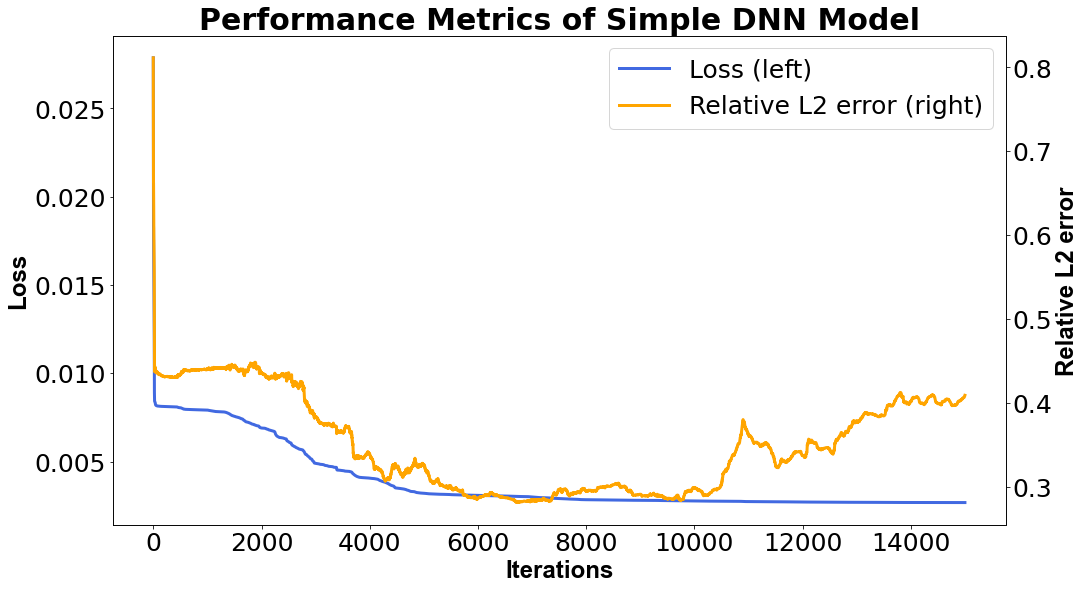

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Simple DNN Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.04278730466871417
MSE =  0.053747987365825485
RMSE =  0.23183612178826984
L2 relative error = 2.118707844169808
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

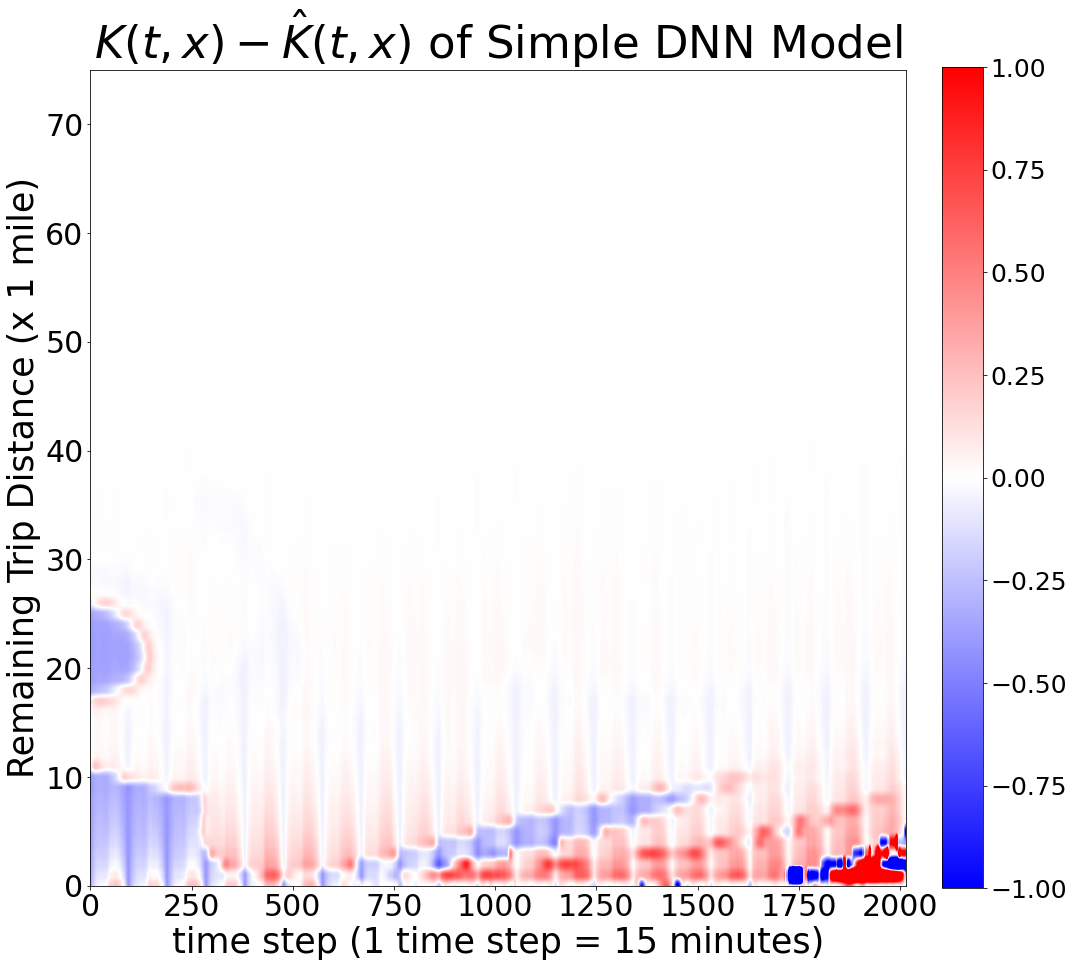

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Simple DNN Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

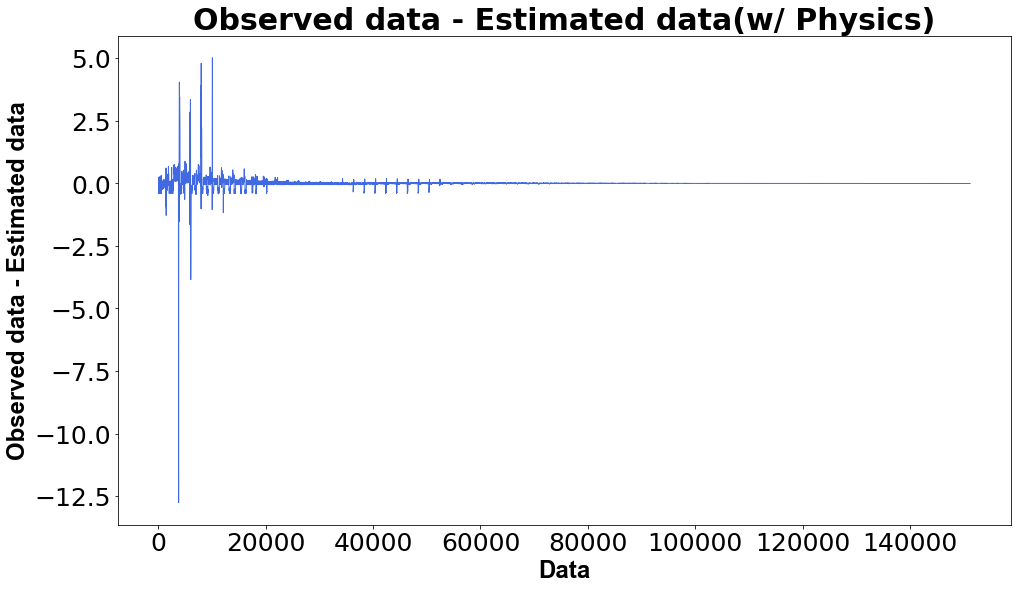

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)